# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 64  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"]/5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 118453.578125
iteration 0 loss 97946.3046875


iteration 500 loss 368.9408874511719


iteration 1000 loss 322.09375


iteration 1500 loss 287.43804931640625


iteration 2000 loss 259.67425537109375


iteration 2500 loss 234.0128173828125


iteration 3000 loss 203.0999298095703


iteration 3500 loss 148.3938751220703


iteration 4000 loss 75.91238403320312


iteration 4500 loss 33.45111846923828


iteration 5000 loss 30.625917434692383


iteration 5500 loss 13.416119575500488


iteration 6000 loss 9.454527854919434


iteration 6500 loss 6.84808874130249


iteration 7000 loss 10.084792137145996


iteration 7500 loss 5.371581077575684


iteration 8000 loss 4.278226852416992


iteration 8500 loss 3.485584259033203


iteration 9000 loss 2.8145751953125


iteration 9500 loss 2.79868221282959


iteration 10000 loss 2.3166096210479736


iteration 10500 loss 1.9472347497940063


iteration 11000 loss 3.0002987384796143


iteration 11500 loss 2.07314133644104


iteration 12000 loss 1.7358355522155762


iteration 12500 loss 1.4954373836517334


iteration 13000 loss 16.6019287109375


iteration 13500 loss 1.557138442993164


iteration 14000 loss 1.2800076007843018


iteration 14500 loss 1.11251699924469


iteration 15000 loss 1.744873046875


iteration 15500 loss 1.0620043277740479


iteration 16000 loss 0.9170777797698975


iteration 16500 loss 1.8053642511367798


iteration 17000 loss 0.946291983127594


iteration 17500 loss 0.8063198924064636


iteration 18000 loss 0.7155893445014954


iteration 18500 loss 0.7497631311416626


iteration 19000 loss 0.6460287570953369


iteration 19500 loss 0.697401762008667


iteration 20000 loss 0.5912684202194214


iteration 20500 loss 0.7662717700004578


iteration 21000 loss 0.5697559714317322


iteration 21500 loss 0.5085763335227966


iteration 22000 loss 0.5583102107048035


iteration 22500 loss 0.4741937518119812


iteration 23000 loss 0.6899157166481018


iteration 23500 loss 0.4809055030345917


iteration 24000 loss 0.4202420711517334


iteration 24500 loss 0.4528307616710663


iteration 25000 loss 0.38480740785598755


iteration 25500 loss 0.45019394159317017


iteration 26000 loss 0.37081414461135864


iteration 26500 loss 0.46600788831710815


iteration 27000 loss 0.3474670946598053


iteration 27500 loss 0.4191123843193054


iteration 28000 loss 0.321856290102005


iteration 28500 loss 0.3421759605407715


iteration 29000 loss 0.3382194936275482


iteration 29500 loss 0.2932926416397095


iteration 30000 loss 0.29715433716773987


iteration 30500 loss 0.3913395404815674


iteration 31000 loss 0.26257508993148804


iteration 31500 loss 0.25331738591194153


iteration 32000 loss 0.26529568433761597


iteration 32500 loss 0.29442957043647766


iteration 33000 loss 0.2311726063489914


iteration 33500 loss 0.23427744209766388


iteration 34000 loss 0.23540112376213074


iteration 34500 loss 0.2900412082672119


iteration 35000 loss 0.20718663930892944


iteration 35500 loss 0.21131546795368195


iteration 36000 loss 0.2472400814294815


iteration 36500 loss 0.1914975792169571


iteration 37000 loss 0.19118385016918182


iteration 37500 loss 0.18552888929843903


iteration 38000 loss 0.18246345221996307


iteration 38500 loss 0.17498339712619781


iteration 39000 loss 0.16908039152622223


iteration 39500 loss 0.16627341508865356


iteration 40000 loss 0.4811345636844635


iteration 40500 loss 0.6132408976554871


iteration 41000 loss 0.47063061594963074


iteration 41500 loss 26.979873657226562


iteration 42000 loss 19.57748031616211


iteration 42500 loss 0.2014651596546173


iteration 43000 loss 0.18242044746875763


iteration 43500 loss 0.1849559247493744


iteration 44000 loss 0.17109443247318268


iteration 44500 loss 0.17000356316566467


iteration 45000 loss 0.1829683929681778


iteration 45500 loss 0.16602985560894012


iteration 46000 loss 0.13784170150756836


iteration 46500 loss 0.13269338011741638


iteration 47000 loss 0.12687259912490845


iteration 47500 loss 0.12387505918741226


iteration 48000 loss 0.11835239827632904


iteration 48500 loss 0.1174006462097168


iteration 49000 loss 0.11625710129737854


iteration 49500 loss 0.12425719946622849


iteration 50000 loss 0.11393298953771591


iteration 50500 loss 0.20355042815208435


iteration 51000 loss 0.1315724402666092


iteration 51500 loss 0.1129746288061142


iteration 52000 loss 0.10443935543298721


iteration 52500 loss 0.18217909336090088


iteration 53000 loss 0.11254487186670303


iteration 53500 loss 2.2787249088287354


iteration 54000 loss 0.10254243016242981


iteration 54500 loss 0.4935511648654938


iteration 55000 loss 0.12979909777641296


iteration 55500 loss 0.09882128983736038


iteration 56000 loss 0.09479404985904694


iteration 56500 loss 0.08959546685218811


iteration 57000 loss 29.59737205505371


iteration 57500 loss 0.10170887410640717


iteration 58000 loss 0.08978068083524704


iteration 58500 loss 0.4047684371471405


iteration 59000 loss 2.0957400798797607


iteration 59500 loss 0.10471897572278976


iteration 60000 loss 0.09718184918165207


iteration 60500 loss 0.08566653728485107


iteration 61000 loss 0.14494898915290833


iteration 61500 loss 0.09102091193199158


iteration 62000 loss 0.08205743879079819


iteration 62500 loss 59.207984924316406


iteration 63000 loss 0.0761328935623169


iteration 63500 loss 0.07971600443124771


iteration 64000 loss 11.6668119430542


iteration 64500 loss 0.07770229130983353


iteration 65000 loss 0.2143547236919403


iteration 65500 loss 0.07138609141111374


iteration 66000 loss 0.08402994275093079


iteration 66500 loss 0.07239602506160736


iteration 67000 loss 0.06960081309080124


iteration 67500 loss 0.06935618817806244


iteration 68000 loss 0.06677454710006714


iteration 68500 loss 0.06911475211381912


iteration 69000 loss 0.08149667829275131


iteration 69500 loss 0.06532474607229233


iteration 70000 loss 0.0698084756731987


iteration 70500 loss 0.09772291779518127


iteration 71000 loss 0.08067256212234497


iteration 71500 loss 0.06466267257928848


iteration 72000 loss 1.6834913492202759


iteration 72500 loss 0.06662014871835709


iteration 73000 loss 0.10570017993450165


iteration 73500 loss 2.053300619125366


iteration 74000 loss 4.305310249328613


iteration 74500 loss 0.20262287557125092


iteration 75000 loss 4.288639068603516


iteration 75500 loss 0.7310243248939514


iteration 76000 loss 0.184173122048378


iteration 76500 loss 7.023432731628418


iteration 77000 loss 4.529341697692871


iteration 77500 loss 0.08060244470834732


iteration 78000 loss 0.09026411920785904


iteration 78500 loss 2.4307868480682373


iteration 79000 loss 8.77785873413086


iteration 79500 loss 0.06248285993933678


iteration 80000 loss 0.1265031397342682


iteration 80500 loss 1.2329638004302979


iteration 81000 loss 9.967436790466309


iteration 81500 loss 2.6605331897735596


iteration 82000 loss 0.11771635711193085


iteration 82500 loss 0.11310677230358124


iteration 83000 loss 0.10177821666002274


iteration 83500 loss 0.4674170911312103


iteration 84000 loss 0.31688740849494934


iteration 84500 loss 0.19666925072669983


iteration 85000 loss 0.06545376777648926


iteration 85500 loss 0.21453911066055298


iteration 86000 loss 0.2388962358236313


iteration 86500 loss 0.051164411008358


iteration 87000 loss 0.3317176103591919


iteration 87500 loss 0.1931440383195877


iteration 88000 loss 0.4622862637042999


iteration 88500 loss 5.4260125160217285


iteration 89000 loss 1.874537467956543


iteration 89500 loss 9.193123817443848


iteration 90000 loss 0.21376876533031464


iteration 90500 loss 0.9671370983123779


iteration 91000 loss 7.673796653747559


iteration 91500 loss 0.18655915558338165


iteration 92000 loss 4.701706409454346


iteration 92500 loss 0.278775691986084


iteration 93000 loss 7.864534378051758


iteration 93500 loss 1.33077871799469


iteration 94000 loss 1.6786714792251587


iteration 94500 loss 0.055808115750551224


iteration 95000 loss 1.4710391759872437


iteration 95500 loss 0.2229575365781784


iteration 96000 loss 0.27098533511161804


iteration 96500 loss 0.35393595695495605


iteration 97000 loss 0.3048763573169708


iteration 97500 loss 1.043458342552185


iteration 98000 loss 6.32197904586792


iteration 98500 loss 0.043978553265333176


iteration 99000 loss 0.5716856718063354


iteration 99500 loss 0.0836801528930664


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 1.0829846858978271


iteration 100500 loss 0.034516919404268265


iteration 101000 loss 0.03246600553393364


iteration 101500 loss 0.030913883820176125


iteration 102000 loss 0.029528314247727394


iteration 102500 loss 0.02820923924446106


iteration 103000 loss 0.026905303820967674


iteration 103500 loss 0.0414908304810524


iteration 104000 loss 0.02481858804821968


iteration 104500 loss 0.023997653275728226


iteration 105000 loss 0.023920023813843727


iteration 105500 loss 0.02276788279414177


iteration 106000 loss 0.022255560383200645


iteration 106500 loss 0.02124781534075737


iteration 107000 loss 0.020663585513830185


iteration 107500 loss 0.02012862265110016


iteration 108000 loss 0.019864702597260475


iteration 108500 loss 0.020800571888685226


iteration 109000 loss 0.02975069172680378


iteration 109500 loss 0.01872248575091362


iteration 110000 loss 0.027539800852537155


iteration 110500 loss 0.017533104866743088


iteration 111000 loss 0.017154010012745857


iteration 111500 loss 0.016788531094789505


iteration 112000 loss 0.016494659706950188


iteration 112500 loss 0.016876637935638428


iteration 113000 loss 0.022373711690306664


iteration 113500 loss 0.015739332884550095


iteration 114000 loss 0.015181167051196098


iteration 114500 loss 0.014872613362967968


iteration 115000 loss 0.014572500251233578


iteration 115500 loss 0.014325842261314392


iteration 116000 loss 0.014033342711627483


iteration 116500 loss 0.013843429274857044


iteration 117000 loss 0.01668599806725979


iteration 117500 loss 0.014334353618323803


iteration 118000 loss 0.013019404374063015


iteration 118500 loss 0.09481001645326614


iteration 119000 loss 0.012609411031007767


iteration 119500 loss 0.01244266889989376


iteration 120000 loss 0.016989827156066895


iteration 120500 loss 0.011908436194062233


iteration 121000 loss 0.018430162221193314


iteration 121500 loss 0.011503889225423336


iteration 122000 loss 0.011304426938295364


iteration 122500 loss 0.014863799326121807


iteration 123000 loss 0.014420534484088421


iteration 123500 loss 0.010730904527008533


iteration 124000 loss 0.014889417216181755


iteration 124500 loss 2.516071081161499


iteration 125000 loss 0.011247163638472557


iteration 125500 loss 0.010072631761431694


iteration 126000 loss 0.015053032897412777


iteration 126500 loss 0.010116498917341232


iteration 127000 loss 0.009585065767168999


iteration 127500 loss 0.009406881406903267


iteration 128000 loss 0.45186561346054077


iteration 128500 loss 0.009270807728171349


iteration 129000 loss 0.008986334316432476


iteration 129500 loss 0.008886253461241722


iteration 130000 loss 0.008761607110500336


iteration 130500 loss 0.04648261517286301


iteration 131000 loss 0.008458294905722141


iteration 131500 loss 0.008300907909870148


iteration 132000 loss 0.008171294815838337


iteration 132500 loss 0.1553679257631302


iteration 133000 loss 0.007958746515214443


iteration 133500 loss 0.007810748182237148


iteration 134000 loss 0.007813558913767338


iteration 134500 loss 0.14596393704414368


iteration 135000 loss 0.008307977579534054


iteration 135500 loss 0.017273709177970886


iteration 136000 loss 0.007327080238610506


iteration 136500 loss 0.007196501828730106


iteration 137000 loss 0.007087633945047855


iteration 137500 loss 0.006976246368139982


iteration 138000 loss 0.006910061463713646


iteration 138500 loss 0.00683646509423852


iteration 139000 loss 0.006623605731874704


iteration 139500 loss 0.006703311111778021


iteration 140000 loss 0.02355349436402321


iteration 140500 loss 0.02323981560766697


iteration 141000 loss 0.006241524126380682


iteration 141500 loss 0.006210963241755962


iteration 142000 loss 0.006094618234783411


iteration 142500 loss 0.005974705331027508


iteration 143000 loss 0.00590855535119772


iteration 143500 loss 0.005816262681037188


iteration 144000 loss 0.007197941187769175


iteration 144500 loss 0.01220319140702486


iteration 145000 loss 0.005570903420448303


iteration 145500 loss 0.005528587847948074


iteration 146000 loss 0.021013954654335976


iteration 146500 loss 0.08901776373386383


iteration 147000 loss 0.005253415554761887


iteration 147500 loss 0.005237463861703873


iteration 148000 loss 0.044814709573984146


iteration 148500 loss 1.2905116081237793


iteration 149000 loss 0.005010086577385664


iteration 149500 loss 0.005234920419752598


iteration 150000 loss 0.004862594418227673


iteration 150500 loss 0.004814429208636284


iteration 151000 loss 0.038397129625082016


iteration 151500 loss 0.005445276387035847


iteration 152000 loss 0.004609704948961735


iteration 152500 loss 0.004571910947561264


iteration 153000 loss 0.34423699975013733


iteration 153500 loss 0.004404004197567701


iteration 154000 loss 0.004466199316084385


iteration 154500 loss 0.24304364621639252


iteration 155000 loss 0.43269094824790955


iteration 155500 loss 0.03399742767214775


iteration 156000 loss 0.0041345045901834965


iteration 156500 loss 0.004098527133464813


iteration 157000 loss 0.026705598458647728


iteration 157500 loss 0.003964878618717194


iteration 158000 loss 0.006996297277510166


iteration 158500 loss 0.0038624885492026806


iteration 159000 loss 0.0038874270394444466


iteration 159500 loss 0.017173605039715767


iteration 160000 loss 0.004027997143566608


iteration 160500 loss 0.003674275940284133


iteration 161000 loss 0.0036401236429810524


iteration 161500 loss 0.022204943001270294


iteration 162000 loss 0.0035702369641512632


iteration 162500 loss 0.003594126319512725


iteration 163000 loss 0.0034362769220024347


iteration 163500 loss 0.0042020478285849094


iteration 164000 loss 0.09970862418413162


iteration 164500 loss 0.0033643916249275208


iteration 165000 loss 0.0032850257121026516


iteration 165500 loss 0.029932377859950066


iteration 166000 loss 0.003196496982127428


iteration 166500 loss 0.0031795252580195665


iteration 167000 loss 0.868891179561615


iteration 167500 loss 0.5608490705490112


iteration 168000 loss 0.0030495752580463886


iteration 168500 loss 0.054020628333091736


iteration 169000 loss 0.0029795051086694


iteration 169500 loss 0.0029442349914461374


iteration 170000 loss 0.003196025500074029


iteration 170500 loss 0.002905759261921048


iteration 171000 loss 0.0028340639546513557


iteration 171500 loss 0.002806982956826687


iteration 172000 loss 0.002838290296494961


iteration 172500 loss 0.0033124855253845453


iteration 173000 loss 0.0027611751575022936


iteration 173500 loss 0.0030446723103523254


iteration 174000 loss 0.040439680218696594


iteration 174500 loss 0.09713244438171387


iteration 175000 loss 0.0656711533665657


iteration 175500 loss 0.010925358161330223


iteration 176000 loss 0.009116245433688164


iteration 176500 loss 0.07428738474845886


iteration 177000 loss 0.12011884152889252


iteration 177500 loss 0.2543049156665802


iteration 178000 loss 0.05122056603431702


iteration 178500 loss 0.10397761315107346


iteration 179000 loss 0.004556060768663883


iteration 179500 loss 0.004098287783563137


iteration 180000 loss 0.15528413653373718


iteration 180500 loss 0.04095768183469772


iteration 181000 loss 0.002236984670162201


iteration 181500 loss 0.00329651334322989


iteration 182000 loss 0.03403647243976593


iteration 182500 loss 0.12878312170505524


iteration 183000 loss 0.11746668070554733


iteration 183500 loss 0.0031517143361270428


iteration 184000 loss 0.009867279790341854


iteration 184500 loss 0.03251032531261444


iteration 185000 loss 0.010291336104273796


iteration 185500 loss 0.19075194001197815


iteration 186000 loss 0.08823360502719879


iteration 186500 loss 0.08710717409849167


iteration 187000 loss 0.05034293234348297


iteration 187500 loss 0.030705880373716354


iteration 188000 loss 0.09349045157432556


iteration 188500 loss 0.08990016579627991


iteration 189000 loss 0.10608966648578644


iteration 189500 loss 0.3015040159225464


iteration 190000 loss 0.11714843660593033


iteration 190500 loss 0.09953109920024872


iteration 191000 loss 0.034909650683403015


iteration 191500 loss 0.022481268271803856


iteration 192000 loss 0.13029666244983673


iteration 192500 loss 0.06027297303080559


iteration 193000 loss 0.009268893860280514


iteration 193500 loss 0.002596830716356635


iteration 194000 loss 0.01653357595205307


iteration 194500 loss 0.04776650667190552


iteration 195000 loss 0.06581740826368332


iteration 195500 loss 0.17586678266525269


iteration 196000 loss 0.16949822008609772


iteration 196500 loss 0.0585402213037014


iteration 197000 loss 0.010190307162702084


iteration 197500 loss 0.15218301117420197


iteration 198000 loss 0.04179006069898605


iteration 198500 loss 0.002678085584193468


iteration 199000 loss 0.001990952994674444


iteration 199500 loss 0.00438344432041049


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.0014743867795914412


iteration 200500 loss 0.001422600937075913


iteration 201000 loss 0.0014132868964225054


iteration 201500 loss 0.001403996255248785


iteration 202000 loss 0.0013933797599747777


iteration 202500 loss 0.0013806871138513088


iteration 203000 loss 0.0013652703491970897


iteration 203500 loss 0.002717586001381278


iteration 204000 loss 0.0013327060732990503


iteration 204500 loss 0.0013202247209846973


iteration 205000 loss 0.0023294396232813597


iteration 205500 loss 0.001284174039028585


iteration 206000 loss 0.001268906518816948


iteration 206500 loss 0.0012543187476694584


iteration 207000 loss 0.0012417020043358207


iteration 207500 loss 0.002340356120839715


iteration 208000 loss 0.030242083594202995


iteration 208500 loss 0.0014184798346832395


iteration 209000 loss 0.0011815950274467468


iteration 209500 loss 0.0011695092543959618


iteration 210000 loss 0.001294609042815864


iteration 210500 loss 0.0012258756905794144


iteration 211000 loss 0.001127938274294138


iteration 211500 loss 0.001116519677452743


iteration 212000 loss 0.001105668256059289


iteration 212500 loss 0.0013652564957737923


iteration 213000 loss 0.0010788916843011975


iteration 213500 loss 0.001064404146745801


iteration 214000 loss 0.001052712555974722


iteration 214500 loss 0.0010562660172581673


iteration 215000 loss 0.0010319664143025875


iteration 215500 loss 0.0010192864574491978


iteration 216000 loss 0.021353308111429214


iteration 216500 loss 0.021611515432596207


iteration 217000 loss 0.0009834583615884185


iteration 217500 loss 0.0009792584460228682


iteration 218000 loss 0.0009627091349102557


iteration 218500 loss 0.000976753537543118


iteration 219000 loss 0.0009408487239852548


iteration 219500 loss 0.0009336398798041046


iteration 220000 loss 0.0018587808590382338


iteration 220500 loss 0.0009564870852045715


iteration 221000 loss 0.0008982629515230656


iteration 221500 loss 0.0008890960598364472


iteration 222000 loss 0.000880399311427027


iteration 222500 loss 0.0008740760385990143


iteration 223000 loss 0.0010407132795080543


iteration 223500 loss 0.0017794700106605887


iteration 224000 loss 0.0008527475874871016


iteration 224500 loss 0.000830079719889909


iteration 225000 loss 0.0008210235391743481


iteration 225500 loss 0.0008204406476579607


iteration 226000 loss 0.0010967693524435163


iteration 226500 loss 0.0007938413764350116


iteration 227000 loss 0.0007865139632485807


iteration 227500 loss 0.000779980153311044


iteration 228000 loss 0.0007708402699790895


iteration 228500 loss 0.0007623943383805454


iteration 229000 loss 0.0008059014216996729


iteration 229500 loss 0.0007533702882938087


iteration 230000 loss 0.0007990800077095628


iteration 230500 loss 0.0007818911108188331


iteration 231000 loss 0.0009627353283576667


iteration 231500 loss 0.0015219220658764243


iteration 232000 loss 0.0007055861060507596


iteration 232500 loss 0.0007008863030932844


iteration 233000 loss 0.0006867924239486456


iteration 233500 loss 0.0006788303726352751


iteration 234000 loss 0.0006739234668202698


iteration 234500 loss 0.0008281983900815248


iteration 235000 loss 0.0007264197338372469


iteration 235500 loss 0.000650541391223669


iteration 236000 loss 0.0006443041493184865


iteration 236500 loss 0.000638980942312628


iteration 237000 loss 0.004442709032446146


iteration 237500 loss 0.0012543925549834967


iteration 238000 loss 0.0006166414823383093


iteration 238500 loss 0.0006184549420140684


iteration 239000 loss 0.0006017490522935987


iteration 239500 loss 0.0005946088931523263


iteration 240000 loss 0.000589195522479713


iteration 240500 loss 0.0005822649109177291


iteration 241000 loss 0.0007259766571223736


iteration 241500 loss 0.0005727903917431831


iteration 242000 loss 0.0005968561745248735


iteration 242500 loss 0.0005568585474975407


iteration 243000 loss 0.0005509376060217619


iteration 243500 loss 0.0005445602582767606


iteration 244000 loss 0.0005389695870690048


iteration 244500 loss 0.0005333925946615636


iteration 245000 loss 0.0005274325958453119


iteration 245500 loss 0.0005219518789090216


iteration 246000 loss 0.0005186427151784301


iteration 246500 loss 0.0005478888633660972


iteration 247000 loss 0.0005054393550381064


iteration 247500 loss 0.0004999967641197145


iteration 248000 loss 0.0004943003295920789


iteration 248500 loss 0.0004898099577985704


iteration 249000 loss 0.0004843739443458617


iteration 249500 loss 0.00048061631969176233


iteration 250000 loss 0.00047562678810209036


iteration 250500 loss 0.0004712385998573154


iteration 251000 loss 0.0004656911769416183


iteration 251500 loss 0.00046065301285125315


iteration 252000 loss 0.0004647278692573309


iteration 252500 loss 0.00045081047574058175


iteration 253000 loss 0.0004769378574565053


iteration 253500 loss 0.00043971327249892056


iteration 254000 loss 0.00043439300497993827


iteration 254500 loss 0.00043098244350403547


iteration 255000 loss 0.00043032277608290315


iteration 255500 loss 0.0004424529033713043


iteration 256000 loss 0.0004179771349299699


iteration 256500 loss 0.0004211722407490015


iteration 257000 loss 0.0004114251059945673


iteration 257500 loss 0.0006678773206658661


iteration 258000 loss 0.00762456189841032


iteration 258500 loss 0.00728970393538475


iteration 259000 loss 0.0730181559920311


iteration 259500 loss 0.009901902638375759


iteration 260000 loss 0.0007613291381858289


iteration 260500 loss 0.0004084416723344475


iteration 261000 loss 0.00037439787411130965


iteration 261500 loss 0.00037150047137402


iteration 262000 loss 0.0003667993878480047


iteration 262500 loss 0.0003651330480352044


iteration 263000 loss 0.0005812087911181152


iteration 263500 loss 0.0019547336269170046


iteration 264000 loss 0.00036884512519463897


iteration 264500 loss 0.0005828985595144331


iteration 265000 loss 0.000344739732099697


iteration 265500 loss 0.0003410005883779377


iteration 266000 loss 0.00033644516952335835


iteration 266500 loss 0.0009849357884377241


iteration 267000 loss 0.0029921806417405605


iteration 267500 loss 0.0003261402016505599


iteration 268000 loss 0.0003228826099075377


iteration 268500 loss 0.02421373501420021


iteration 269000 loss 0.012645385228097439


iteration 269500 loss 0.00031253654742613435


iteration 270000 loss 0.00034383570891804993


iteration 270500 loss 0.0003112259437330067


iteration 271000 loss 0.001210103160701692


iteration 271500 loss 0.0027419524267315865


iteration 272000 loss 0.0002961109858006239


iteration 272500 loss 0.0002945775049738586


iteration 273000 loss 0.00029011996230110526


iteration 273500 loss 0.0002883841807488352


iteration 274000 loss 0.0003059048030991107


iteration 274500 loss 0.00028254714561626315


iteration 275000 loss 0.0002783816889859736


iteration 275500 loss 0.00027560090529732406


iteration 276000 loss 0.0002736808964982629


iteration 276500 loss 0.00026953991618938744


iteration 277000 loss 0.00026871621957980096


iteration 277500 loss 0.0035396399907767773


iteration 278000 loss 0.0007863838109187782


iteration 278500 loss 0.00025800871662795544


iteration 279000 loss 0.00026121543487533927


iteration 279500 loss 0.0006296606152318418


iteration 280000 loss 0.00025222328258678317


iteration 280500 loss 0.003270181128755212


iteration 281000 loss 0.00024477599072270095


iteration 281500 loss 0.00024349834711756557


iteration 282000 loss 0.00024084116739686579


iteration 282500 loss 0.0002542355505283922


iteration 283000 loss 0.0003660506336018443


iteration 283500 loss 0.00031441025203093886


iteration 284000 loss 0.0002795318141579628


iteration 284500 loss 0.0003136303275823593


iteration 285000 loss 0.018704937770962715


iteration 285500 loss 0.0002245170035166666


iteration 286000 loss 0.00022124333190731704


iteration 286500 loss 0.00021854171063750982


iteration 287000 loss 0.00021626932721119374


iteration 287500 loss 0.00023005317780189216


iteration 288000 loss 0.06476063281297684


iteration 288500 loss 0.0002143093734048307


iteration 289000 loss 0.0004189656756352633


iteration 289500 loss 0.00021227473916951567


iteration 290000 loss 0.00020261983445379883


iteration 290500 loss 0.0002186234196415171


iteration 291000 loss 0.00031599635258316994


iteration 291500 loss 0.00020731796394102275


iteration 292000 loss 0.0001947373675648123


iteration 292500 loss 0.0001924563111970201


iteration 293000 loss 0.00019090175919700414


iteration 293500 loss 0.0001941345544764772


iteration 294000 loss 0.00018691510194912553


iteration 294500 loss 0.00018474477110430598


iteration 295000 loss 0.00018338464724365622


iteration 295500 loss 0.00018182682106271386


iteration 296000 loss 0.0001863061625044793


iteration 296500 loss 0.0002432684414088726


iteration 297000 loss 0.0003772360214497894


iteration 297500 loss 0.000173907246789895


iteration 298000 loss 0.00021584467322099954


iteration 298500 loss 0.00024865567684173584


iteration 299000 loss 0.00023512565530836582


iteration 299500 loss 0.07988996058702469


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.0001715052785584703


iteration 300500 loss 0.00016339565627276897


iteration 301000 loss 0.0001627432502573356


iteration 301500 loss 0.00016201927792280912


iteration 302000 loss 0.0001611464685993269


iteration 302500 loss 0.00016004606732167304


iteration 303000 loss 0.00015863601583987474


iteration 303500 loss 0.000177551424712874


iteration 304000 loss 0.00015571359836030751


iteration 304500 loss 0.00016034995496738702


iteration 305000 loss 0.00015290211013052613


iteration 305500 loss 0.00015140220057219267


iteration 306000 loss 0.0003663914685603231


iteration 306500 loss 0.00014863944670651108


iteration 307000 loss 0.000147654049214907


iteration 307500 loss 0.0001459101476939395


iteration 308000 loss 0.00014438328798860312


iteration 308500 loss 0.00014341728819999844


iteration 309000 loss 0.00014177824778016657


iteration 309500 loss 0.00014098119572736323


iteration 310000 loss 0.00013943383237347007


iteration 310500 loss 0.00013797477004118264


iteration 311000 loss 0.00013670262706000358


iteration 311500 loss 0.00013531319564208388


iteration 312000 loss 0.00038280358421616256


iteration 312500 loss 0.0001328577782260254


iteration 313000 loss 0.00013378032599575818


iteration 313500 loss 0.00013055097952019423


iteration 314000 loss 0.0001292015367653221


iteration 314500 loss 0.00013312029477674514


iteration 315000 loss 0.00012673989112954587


iteration 315500 loss 0.00013253395445644855


iteration 316000 loss 0.0001244600716745481


iteration 316500 loss 0.00012337310181465


iteration 317000 loss 0.00012222242366988212


iteration 317500 loss 0.00012110078387195244


iteration 318000 loss 0.00011998135596513748


iteration 318500 loss 0.00011871413880726323


iteration 319000 loss 0.0002762409276328981


iteration 319500 loss 0.00011649517546175048


iteration 320000 loss 0.00011699640162987635


iteration 320500 loss 0.000114481445052661


iteration 321000 loss 0.00011363156954757869


iteration 321500 loss 0.00011709672980941832


iteration 322000 loss 0.00011125965102110058


iteration 322500 loss 0.0001113366088247858


iteration 323000 loss 0.00010926745744654909


iteration 323500 loss 0.00010824319906532764


iteration 324000 loss 0.00010767559433588758


iteration 324500 loss 0.00010623173147905618


iteration 325000 loss 0.00010551072045927867


iteration 325500 loss 0.00010422722698422149


iteration 326000 loss 0.0007061159703880548


iteration 326500 loss 0.00010234360524918884


iteration 327000 loss 0.00010247286263620481


iteration 327500 loss 0.00010042656504083425


iteration 328000 loss 9.950354433385655e-05


iteration 328500 loss 9.856658289209008e-05


iteration 329000 loss 9.781869448488578e-05


iteration 329500 loss 9.681858500698581e-05


iteration 330000 loss 9.590090485289693e-05


iteration 330500 loss 9.500968735665083e-05


iteration 331000 loss 9.6198680694215e-05


iteration 331500 loss 9.33780538616702e-05


iteration 332000 loss 9.236738696927205e-05


iteration 332500 loss 9.161650814348832e-05


iteration 333000 loss 9.116984438151121e-05


iteration 333500 loss 8.988014451460913e-05


iteration 334000 loss 9.040831355378032e-05


iteration 334500 loss 8.826454723021016e-05


iteration 335000 loss 8.827923011267558e-05


iteration 335500 loss 8.777681068750098e-05


iteration 336000 loss 8.589120989199728e-05


iteration 336500 loss 8.563285518903285e-05


iteration 337000 loss 8.480762335238978e-05


iteration 337500 loss 8.348406117875129e-05


iteration 338000 loss 0.0001922669616760686


iteration 338500 loss 8.212878310587257e-05


iteration 339000 loss 8.286730735562742e-05


iteration 339500 loss 8.063823042903095e-05


iteration 340000 loss 0.00011007764987880364


iteration 340500 loss 7.921998621895909e-05


iteration 341000 loss 8.016340871108696e-05


iteration 341500 loss 7.797896978445351e-05


iteration 342000 loss 7.68999379943125e-05


iteration 342500 loss 8.378802158404142e-05


iteration 343000 loss 7.55674482206814e-05


iteration 343500 loss 8.600645378464833e-05


iteration 344000 loss 7.412026752717793e-05


iteration 344500 loss 7.396597357001156e-05


iteration 345000 loss 7.277531403815374e-05


iteration 345500 loss 0.003047399688512087


iteration 346000 loss 7.157153595471755e-05


iteration 346500 loss 7.42016636650078e-05


iteration 347000 loss 7.040885247988626e-05


iteration 347500 loss 6.957085861358792e-05


iteration 348000 loss 0.0003725946880877018


iteration 348500 loss 6.83808684698306e-05


iteration 349000 loss 7.973009633133188e-05


iteration 349500 loss 6.707366992486641e-05


iteration 350000 loss 0.0002570433425717056


iteration 350500 loss 6.58742428640835e-05


iteration 351000 loss 6.544842472067103e-05


iteration 351500 loss 6.471900269389153e-05


iteration 352000 loss 6.432864029193297e-05


iteration 352500 loss 6.360721454257146e-05


iteration 353000 loss 6.501643656520173e-05


iteration 353500 loss 6.24504464212805e-05


iteration 354000 loss 6.324992136796936e-05


iteration 354500 loss 6.132026464911178e-05


iteration 355000 loss 6.161480268929154e-05


iteration 355500 loss 6.031110024196096e-05


iteration 356000 loss 6.49408611934632e-05


iteration 356500 loss 5.911084735998884e-05


iteration 357000 loss 5.928708196734078e-05


iteration 357500 loss 5.810508446302265e-05


iteration 358000 loss 5.741656423197128e-05


iteration 358500 loss 5.7051918702200055e-05


iteration 359000 loss 6.11361101618968e-05


iteration 359500 loss 5.595538459601812e-05


iteration 360000 loss 5.84791814617347e-05


iteration 360500 loss 5.494626020663418e-05


iteration 361000 loss 5.447518560686149e-05


iteration 361500 loss 5.39493776159361e-05


iteration 362000 loss 5.839753066538833e-05


iteration 362500 loss 5.300528937368654e-05


iteration 363000 loss 5.644595512421802e-05


iteration 363500 loss 5.184838664717972e-05


iteration 364000 loss 5.590569708147086e-05


iteration 364500 loss 5.091050115879625e-05


iteration 365000 loss 7.457502942997962e-05


iteration 365500 loss 4.9971145926974714e-05


iteration 366000 loss 4.985017221770249e-05


iteration 366500 loss 4.911774885840714e-05


iteration 367000 loss 4.915654790238477e-05


iteration 367500 loss 4.818112574866973e-05


iteration 368000 loss 4.807542063645087e-05


iteration 368500 loss 4.734573303721845e-05


iteration 369000 loss 4.854900544160046e-05


iteration 369500 loss 4.6479766751872376e-05


iteration 370000 loss 4.6240769734140486e-05


iteration 370500 loss 4.5689186663366854e-05


iteration 371000 loss 4.5253684220369905e-05


iteration 371500 loss 4.694449307862669e-05


iteration 372000 loss 4.449303014553152e-05


iteration 372500 loss 4.46696431026794e-05


iteration 373000 loss 4.3656807974912226e-05


iteration 373500 loss 4.326972702983767e-05


iteration 374000 loss 4.290750075597316e-05


iteration 374500 loss 4.272445585229434e-05


iteration 375000 loss 4.232078208588064e-05


iteration 375500 loss 4.171763430349529e-05


iteration 376000 loss 4.1870735003612936e-05


iteration 376500 loss 4.0959454054245725e-05


iteration 377000 loss 0.00015553411503788084


iteration 377500 loss 4.023659857921302e-05


iteration 378000 loss 4.8406280257040635e-05


iteration 378500 loss 3.9493635995313525e-05


iteration 379000 loss 3.930061939172447e-05


iteration 379500 loss 3.880709482473321e-05


iteration 380000 loss 3.846806430374272e-05


iteration 380500 loss 0.00023793563013896346


iteration 381000 loss 3.771584670175798e-05


iteration 381500 loss 3.752277552848682e-05


iteration 382000 loss 3.711926910909824e-05


iteration 382500 loss 3.672582170111127e-05


iteration 383000 loss 4.162606637692079e-05


iteration 383500 loss 3.745109643205069e-05


iteration 384000 loss 3.5790642868960276e-05


iteration 384500 loss 0.007292629685252905


iteration 385000 loss 3.657925481093116e-05


iteration 385500 loss 3.477560676401481e-05


iteration 386000 loss 3.4699933166848496e-05


iteration 386500 loss 3.414548700675368e-05


iteration 387000 loss 3.612237924244255e-05


iteration 387500 loss 3.343851858517155e-05


iteration 388000 loss 3.32285271724686e-05


iteration 388500 loss 5.334213710739277e-05


iteration 389000 loss 3.261989331804216e-05


iteration 389500 loss 3.259848017478362e-05


iteration 390000 loss 3.216442564735189e-05


iteration 390500 loss 3.171944626956247e-05


iteration 391000 loss 3.165558882756159e-05


iteration 391500 loss 3.403034133953042e-05


iteration 392000 loss 3.1335574021795765e-05


iteration 392500 loss 3.06626534438692e-05


iteration 393000 loss 0.0007307094638235867


iteration 393500 loss 3.005271173606161e-05


iteration 394000 loss 2.9918788641225547e-05


iteration 394500 loss 3.282723992015235e-05


iteration 395000 loss 2.9321729016373865e-05


iteration 395500 loss 2.897697049775161e-05


iteration 396000 loss 2.8820990337408148e-05


iteration 396500 loss 2.8494661819422618e-05


iteration 397000 loss 2.8205453418195248e-05


iteration 397500 loss 0.00012746703578159213


iteration 398000 loss 2.8378515708027408e-05


iteration 398500 loss 2.7494001187733375e-05


iteration 399000 loss 6.793314969399944e-05


iteration 399500 loss 2.6915287890005857e-05


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 2.667214175744448e-05


iteration 400500 loss 2.6616891773301177e-05


iteration 401000 loss 2.6556605007499456e-05


iteration 401500 loss 2.647658584464807e-05


iteration 402000 loss 2.6375009838375263e-05


iteration 402500 loss 2.6239453291054815e-05


iteration 403000 loss 2.6060151867568493e-05


iteration 403500 loss 2.5823801479418762e-05


iteration 404000 loss 0.0008383159292861819


iteration 404500 loss 2.5406818167539313e-05


iteration 405000 loss 2.5261011614929885e-05


iteration 405500 loss 2.512086575734429e-05


iteration 406000 loss 2.4831368136801757e-05


iteration 406500 loss 2.5719462428241968e-05


iteration 407000 loss 2.4452867364743724e-05


iteration 407500 loss 2.4310093067470007e-05


iteration 408000 loss 2.413907350273803e-05


iteration 408500 loss 2.425008460704703e-05


iteration 409000 loss 2.369969843130093e-05


iteration 409500 loss 2.354311254748609e-05


iteration 410000 loss 2.3351894924417138e-05


iteration 410500 loss 2.3235612388816662e-05


iteration 411000 loss 2.2972435544943437e-05


iteration 411500 loss 2.2813346731709316e-05


iteration 412000 loss 2.258747917949222e-05


iteration 412500 loss 2.2407093638321385e-05


iteration 413000 loss 2.2255042495089583e-05


iteration 413500 loss 2.2109537894721143e-05


iteration 414000 loss 2.201660754508339e-05


iteration 414500 loss 2.173635584767908e-05


iteration 415000 loss 2.1580523025477305e-05


iteration 415500 loss 2.1437997929751873e-05


iteration 416000 loss 2.1745547201135196e-05


iteration 416500 loss 2.10593225347111e-05


iteration 417000 loss 2.0916360881528817e-05


iteration 417500 loss 2.0774370568688028e-05


iteration 418000 loss 2.056171615549829e-05


iteration 418500 loss 2.041004154307302e-05


iteration 419000 loss 2.0281499018892646e-05


iteration 419500 loss 2.020388092205394e-05


iteration 420000 loss 1.990317650779616e-05


iteration 420500 loss 1.9778784917434677e-05


iteration 421000 loss 1.9659897589008324e-05


iteration 421500 loss 1.9532595615601167e-05


iteration 422000 loss 1.9765173419727944e-05


iteration 422500 loss 1.91913204616867e-05


iteration 423000 loss 1.9049542970606126e-05


iteration 423500 loss 1.8938808352686465e-05


iteration 424000 loss 1.8849341358873062e-05


iteration 424500 loss 1.8675953469937667e-05


iteration 425000 loss 1.848212195909582e-05


iteration 425500 loss 1.835162765928544e-05


iteration 426000 loss 1.8308437574887648e-05


iteration 426500 loss 1.8043538148049265e-05


iteration 427000 loss 1.7921509424922988e-05


iteration 427500 loss 1.7801366993808188e-05


iteration 428000 loss 1.7566924725542776e-05


iteration 428500 loss 1.7498978195362724e-05


iteration 429000 loss 1.7382026271661744e-05


iteration 429500 loss 1.7277690858463757e-05


iteration 430000 loss 1.7136679161922075e-05


iteration 430500 loss 1.6975862308754586e-05


iteration 431000 loss 1.6859125025803223e-05


iteration 431500 loss 1.675438579695765e-05


iteration 432000 loss 1.6612364561297e-05


iteration 432500 loss 1.6457222955068573e-05


iteration 433000 loss 1.635397711652331e-05


iteration 433500 loss 1.643710129428655e-05


iteration 434000 loss 1.609758510312531e-05


iteration 434500 loss 1.5968809748301283e-05


iteration 435000 loss 1.5861694919294678e-05


iteration 435500 loss 1.5681198419770226e-05


iteration 436000 loss 1.558833901071921e-05


iteration 436500 loss 1.5499081200687215e-05


iteration 437000 loss 1.539404911454767e-05


iteration 437500 loss 7.58000896894373e-05


iteration 438000 loss 1.5133130546018947e-05


iteration 438500 loss 1.50276355270762e-05


iteration 439000 loss 1.4964347428758629e-05


iteration 439500 loss 1.476457964599831e-05


iteration 440000 loss 1.467780748498626e-05


iteration 440500 loss 1.4625331459683366e-05


iteration 441000 loss 1.4668821677332744e-05


iteration 441500 loss 1.432913813914638e-05


iteration 442000 loss 1.4240079508454073e-05


iteration 442500 loss 1.4323998584586661e-05


iteration 443000 loss 0.00034674935159273446


iteration 443500 loss 1.3906908861827105e-05


iteration 444000 loss 1.382257596560521e-05


iteration 444500 loss 1.4159945749270264e-05


iteration 445000 loss 1.3638493328471668e-05


iteration 445500 loss 1.3502928595698904e-05


iteration 446000 loss 1.341188635706203e-05


iteration 446500 loss 1.3290421520650852e-05


iteration 447000 loss 1.3198503438616171e-05


iteration 447500 loss 1.3104992831358686e-05


iteration 448000 loss 1.3021984159422573e-05


iteration 448500 loss 1.2962418622919358e-05


iteration 449000 loss 1.2807759048882872e-05


iteration 449500 loss 1.2718775906250812e-05


iteration 450000 loss 1.2692361451627221e-05


iteration 450500 loss 1.2602739843714517e-05


iteration 451000 loss 1.2423290172591805e-05


iteration 451500 loss 1.234233241120819e-05


iteration 452000 loss 1.2241367585374974e-05


iteration 452500 loss 1.2184771549073048e-05


iteration 453000 loss 1.2064475413353648e-05


iteration 453500 loss 1.1993333828286268e-05


iteration 454000 loss 1.2189161679998506e-05


iteration 454500 loss 1.1786319191742223e-05


iteration 455000 loss 1.1708412785083055e-05


iteration 455500 loss 1.1595609066716861e-05


iteration 456000 loss 1.153749690274708e-05


iteration 456500 loss 1.1451035788923036e-05


iteration 457000 loss 1.1385142897779588e-05


iteration 457500 loss 1.1312644346617162e-05


iteration 458000 loss 1.1249318049522117e-05


iteration 458500 loss 1.1113209438917693e-05


iteration 459000 loss 1.1043447557312902e-05


iteration 459500 loss 1.0952638149319682e-05


iteration 460000 loss 1.0878328794206027e-05


iteration 460500 loss 1.0796438800753094e-05


iteration 461000 loss 1.0733489943959285e-05


iteration 461500 loss 0.0006102988845668733


iteration 462000 loss 1.054839049174916e-05


iteration 462500 loss 1.0485717211849988e-05


iteration 463000 loss 1.0442488019180018e-05


iteration 463500 loss 1.0355458471167367e-05


iteration 464000 loss 1.0257319445372559e-05


iteration 464500 loss 1.0188617125095334e-05


iteration 465000 loss 1.025888923322782e-05


iteration 465500 loss 1.0026021300291177e-05


iteration 466000 loss 9.964444871002343e-06


iteration 466500 loss 1.0231304258923046e-05


iteration 467000 loss 1.0175257557420991e-05


iteration 467500 loss 9.745332135935314e-06


iteration 468000 loss 9.68411495705368e-06


iteration 468500 loss 1.0325641596864443e-05


iteration 469000 loss 9.584572580934037e-06


iteration 469500 loss 9.468349162489176e-06


iteration 470000 loss 9.406901881447993e-06


iteration 470500 loss 9.527977454126813e-06


iteration 471000 loss 9.27538530959282e-06


iteration 471500 loss 9.19945705391001e-06


iteration 472000 loss 9.173061698675156e-06


iteration 472500 loss 2.4345423298655078e-05


iteration 473000 loss 8.994388736027759e-06


iteration 473500 loss 8.947941751102917e-06


iteration 474000 loss 8.910235010262113e-06


iteration 474500 loss 8.802371667115949e-06


iteration 475000 loss 8.750589586270507e-06


iteration 475500 loss 9.102763215196319e-06


iteration 476000 loss 8.64692083268892e-06


iteration 476500 loss 8.561393769923598e-06


iteration 477000 loss 8.508050086675212e-06


iteration 477500 loss 8.558908120903652e-06


iteration 478000 loss 8.370329851459246e-06


iteration 478500 loss 8.320128472405486e-06


iteration 479000 loss 8.25538609205978e-06


iteration 479500 loss 1.5471652659471147e-05


iteration 480000 loss 8.126157808874268e-06


iteration 480500 loss 8.077360689640045e-06


iteration 481000 loss 8.008702025108505e-06


iteration 481500 loss 7.97828943177592e-06


iteration 482000 loss 7.900236596469767e-06


iteration 482500 loss 7.853906026866753e-06


iteration 483000 loss 7.842942977731582e-06


iteration 483500 loss 7.749683391011786e-06


iteration 484000 loss 7.69435428082943e-06


iteration 484500 loss 7.642856871825643e-06


iteration 485000 loss 7.5783445936394855e-06


iteration 485500 loss 7.537496003351407e-06


iteration 486000 loss 7.483803983632242e-06


iteration 486500 loss 7.600594926771009e-06


iteration 487000 loss 7.3843193604261614e-06


iteration 487500 loss 7.328803803829942e-06


iteration 488000 loss 7.30094734535669e-06


iteration 488500 loss 7.907348845037632e-06


iteration 489000 loss 7.174409802246373e-06


iteration 489500 loss 7.134698989830213e-06


iteration 490000 loss 7.060007646941813e-06


iteration 490500 loss 7.04749936630833e-06


iteration 491000 loss 6.987075266806642e-06


iteration 491500 loss 6.9490893110923935e-06


iteration 492000 loss 6.86660405335715e-06


iteration 492500 loss 6.840642981842393e-06


iteration 493000 loss 6.7976002355862875e-06


iteration 493500 loss 6.738933734595776e-06


iteration 494000 loss 6.724558716086904e-06


iteration 494500 loss 6.657889116468141e-06


iteration 495000 loss 6.73652493787813e-06


iteration 495500 loss 6.793911779823247e-06


iteration 496000 loss 6.5202721089008264e-06


iteration 496500 loss 6.4791411205078475e-06


iteration 497000 loss 6.652828233200125e-06


iteration 497500 loss 6.383114850905258e-06


iteration 498000 loss 6.350677267619176e-06


iteration 498500 loss 6.307820058282232e-06


iteration 499000 loss 6.6221509769093245e-06


iteration 499500 loss 6.232895430002827e-06


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss -75.92306518554688


loss -306.2022399902344


loss -410.85430908203125


loss -495.506591796875


loss -572.7210083007812


loss -642.447265625


loss -703.0039672851562


loss -751.6101684570312


loss -785.0227661132812


loss -802.4500122070312


loss -808.4476318359375


loss -809.6587524414062


loss -809.7901000976562


loss -809.797119140625


loss -809.79736328125


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.7973022460938


loss -809.7972412109375


loss -809.7973022460938


loss -809.7973022460938


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.79736328125


loss -809.7972412109375


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.7972412109375


loss -809.7972412109375


loss -809.7973022460938


loss -809.79736328125


loss -809.7973022460938


loss -809.7973022460938


loss -809.7972412109375


final mse:  9.111735255196152e-10
max, min: 4.4776974 -4.476545
loss -75.92306518554688


loss -302.6585693359375


loss -407.24603271484375


loss -493.8074035644531


loss -573.46630859375


loss -645.8965454101562


loss -709.2269287109375


loss -760.5357666015625


loss -796.373291015625


loss -815.443115234375


loss -822.027099609375


loss -823.3048095703125


loss -823.4309692382812


loss -823.4367065429688


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


loss -823.4368896484375


loss -823.4368286132812


final mse:  5.600930275129201e-10
max, min: 4.346436 -4.602657


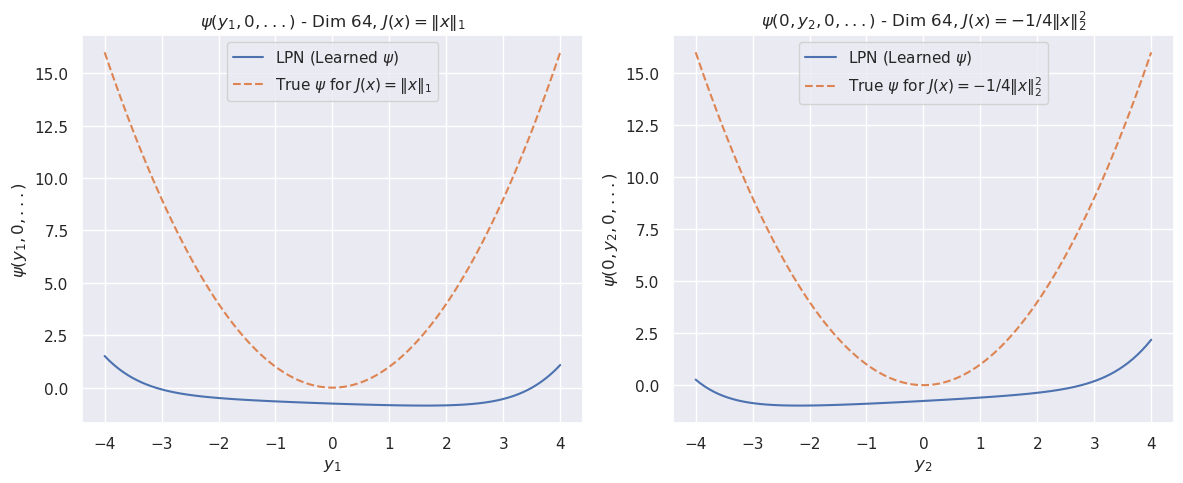

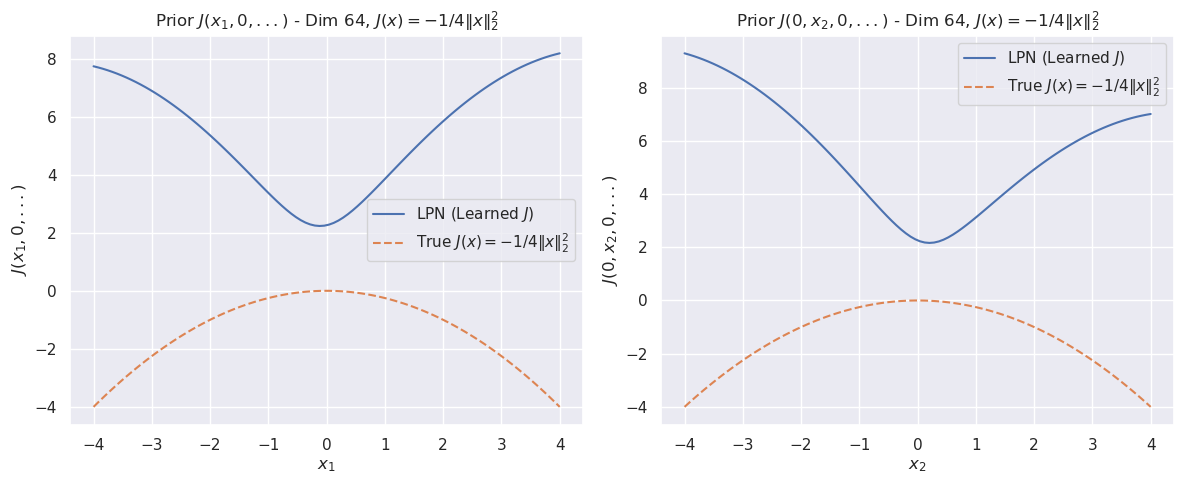

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"]/5 # * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 71219.453125
iteration 0 loss 36370.078125


iteration 500 loss 45.22772979736328


iteration 1000 loss 35.77778244018555


iteration 1500 loss 28.922592163085938


iteration 2000 loss 23.844314575195312


iteration 2500 loss 19.812562942504883


iteration 3000 loss 16.636798858642578


iteration 3500 loss 14.036124229431152


iteration 4000 loss 11.88840389251709


iteration 4500 loss 10.075477600097656


iteration 5000 loss 13.598931312561035


iteration 5500 loss 7.668290615081787


iteration 6000 loss 42.42234420776367


iteration 6500 loss 6.311619281768799


iteration 7000 loss 5.750775337219238


iteration 7500 loss 5.460962295532227


iteration 8000 loss 4.901520252227783


iteration 8500 loss 4.518281936645508


iteration 9000 loss 4.078148365020752


iteration 9500 loss 3.951181173324585


iteration 10000 loss 3.7055487632751465


iteration 10500 loss 3.4160072803497314


iteration 11000 loss 3.2452402114868164


iteration 11500 loss 3.0053889751434326


iteration 12000 loss 2.7840826511383057


iteration 12500 loss 2.5222883224487305


iteration 13000 loss 2.521608829498291


iteration 13500 loss 2.3628923892974854


iteration 14000 loss 2.1967904567718506


iteration 14500 loss 2.020252227783203


iteration 15000 loss 1.9380052089691162


iteration 15500 loss 1.789032220840454


iteration 16000 loss 1.6331971883773804


iteration 16500 loss 1.7101515531539917


iteration 17000 loss 1.5855731964111328


iteration 17500 loss 1.4766268730163574


iteration 18000 loss 1.3593894243240356


iteration 18500 loss 1.4616830348968506


iteration 19000 loss 1.2478735446929932


iteration 19500 loss 1.1476472616195679


iteration 20000 loss 1.0418977737426758


iteration 20500 loss 1.1407287120819092


iteration 21000 loss 1.0415326356887817


iteration 21500 loss 0.9590386748313904


iteration 22000 loss 0.8722425699234009


iteration 22500 loss 0.9131042957305908


iteration 23000 loss 0.8248223662376404


iteration 23500 loss 0.7550767660140991


iteration 24000 loss 0.8953642249107361


iteration 24500 loss 0.7786198258399963


iteration 25000 loss 0.7089343667030334


iteration 25500 loss 0.6486773490905762


iteration 26000 loss 0.8580937385559082


iteration 26500 loss 0.6960317492485046


iteration 27000 loss 0.6221626400947571


iteration 27500 loss 0.5669422745704651


iteration 28000 loss 0.8263334035873413


iteration 28500 loss 0.5923983454704285


iteration 29000 loss 0.5276793837547302


iteration 29500 loss 0.48003143072128296


iteration 30000 loss 0.58719402551651


iteration 30500 loss 0.49034643173217773


iteration 31000 loss 0.44287723302841187


iteration 31500 loss 177.5819854736328


iteration 32000 loss 0.4683474600315094


iteration 32500 loss 0.4123368561267853


iteration 33000 loss 0.3743875324726105


iteration 33500 loss 0.423583984375


iteration 34000 loss 0.36645516753196716


iteration 34500 loss 0.3341142535209656


iteration 35000 loss 0.35362184047698975


iteration 35500 loss 0.31280410289764404


iteration 36000 loss 0.3393634557723999


iteration 36500 loss 0.2931622862815857


iteration 37000 loss 0.42825087904930115


iteration 37500 loss 0.3137199580669403


iteration 38000 loss 0.277604341506958


iteration 38500 loss 12.641515731811523


iteration 39000 loss 0.2638552486896515


iteration 39500 loss 0.23753216862678528


iteration 40000 loss 0.2547748386859894


iteration 40500 loss 0.22733256220817566


iteration 41000 loss 0.24573951959609985


iteration 41500 loss 0.2144824117422104


iteration 42000 loss 0.22096489369869232


iteration 42500 loss 0.20599059760570526


iteration 43000 loss 0.23371493816375732


iteration 43500 loss 0.20049667358398438


iteration 44000 loss 0.3936373293399811


iteration 44500 loss 0.1853361874818802


iteration 45000 loss 0.22704161703586578


iteration 45500 loss 0.18041637539863586


iteration 46000 loss 0.2348041981458664


iteration 46500 loss 0.16905571520328522


iteration 47000 loss 0.2030259668827057


iteration 47500 loss 0.1607019007205963


iteration 48000 loss 0.18424934148788452


iteration 48500 loss 0.15081515908241272


iteration 49000 loss 0.17226830124855042


iteration 49500 loss 0.14363427460193634


iteration 50000 loss 0.15707790851593018


iteration 50500 loss 0.14579983055591583


iteration 51000 loss 0.13700518012046814


iteration 51500 loss 0.13856364786624908


iteration 52000 loss 0.13627219200134277


iteration 52500 loss 0.8609361052513123


iteration 53000 loss 0.12152808159589767


iteration 53500 loss 0.12592558562755585


iteration 54000 loss 0.35673847794532776


iteration 54500 loss 0.11257243156433105


iteration 55000 loss 0.11644160002470016


iteration 55500 loss 0.11056962609291077


iteration 56000 loss 0.11318852007389069


iteration 56500 loss 0.10868191719055176


iteration 57000 loss 0.10102382302284241


iteration 57500 loss 0.11697179824113846


iteration 58000 loss 0.10141922533512115


iteration 58500 loss 0.09630892425775528


iteration 59000 loss 0.09295573830604553


iteration 59500 loss 5.323756217956543


iteration 60000 loss 0.08996143937110901


iteration 60500 loss 1.118595004081726


iteration 61000 loss 0.09199145436286926


iteration 61500 loss 0.09477804601192474


iteration 62000 loss 0.08586227893829346


iteration 62500 loss 0.08309978991746902


iteration 63000 loss 0.08200594782829285


iteration 63500 loss 0.07828366011381149


iteration 64000 loss 0.08737969398498535


iteration 64500 loss 0.08291120082139969


iteration 65000 loss 0.08154888451099396


iteration 65500 loss 0.07479895651340485


iteration 66000 loss 0.07269599288702011


iteration 66500 loss 0.08239386230707169


iteration 67000 loss 0.07034295797348022


iteration 67500 loss 0.08175397664308548


iteration 68000 loss 0.06843287497758865


iteration 68500 loss 0.06961072236299515


iteration 69000 loss 0.06727129966020584


iteration 69500 loss 0.06402004510164261


iteration 70000 loss 0.08928516507148743


iteration 70500 loss 0.06749002635478973


iteration 71000 loss 0.06168736517429352


iteration 71500 loss 0.06976255774497986


iteration 72000 loss 0.08079259842634201


iteration 72500 loss 0.0585920512676239


iteration 73000 loss 0.059971097856760025


iteration 73500 loss 0.06121294945478439


iteration 74000 loss 0.05667717009782791


iteration 74500 loss 0.05491543933749199


iteration 75000 loss 0.06359010189771652


iteration 75500 loss 0.06017087772488594


iteration 76000 loss 0.053204528987407684


iteration 76500 loss 0.05252483859658241


iteration 77000 loss 1.121458888053894


iteration 77500 loss 6.616101264953613


iteration 78000 loss 0.05786408483982086


iteration 78500 loss 3.456244468688965


iteration 79000 loss 0.05084824189543724


iteration 79500 loss 0.048679083585739136


iteration 80000 loss 0.04902860149741173


iteration 80500 loss 0.0505494624376297


iteration 81000 loss 0.046381235122680664


iteration 81500 loss 0.049208566546440125


iteration 82000 loss 0.047701627016067505


iteration 82500 loss 0.049229636788368225


iteration 83000 loss 0.04984305799007416


iteration 83500 loss 0.04487503692507744


iteration 84000 loss 1.037401556968689


iteration 84500 loss 0.04827189818024635


iteration 85000 loss 2.3465969562530518


iteration 85500 loss 0.18283964693546295


iteration 86000 loss 0.1463778018951416


iteration 86500 loss 1.9470335245132446


iteration 87000 loss 0.23540301620960236


iteration 87500 loss 2.564577579498291


iteration 88000 loss 0.07574152946472168


iteration 88500 loss 0.18544821441173553


iteration 89000 loss 0.4393403232097626


iteration 89500 loss 0.07738751173019409


iteration 90000 loss 1.759541392326355


iteration 90500 loss 0.4763241112232208


iteration 91000 loss 0.054016586393117905


iteration 91500 loss 0.20832660794258118


iteration 92000 loss 1.6770155429840088


iteration 92500 loss 0.2646993100643158


iteration 93000 loss 2.043647289276123


iteration 93500 loss 0.3622809946537018


iteration 94000 loss 0.17538060247898102


iteration 94500 loss 0.16208602488040924


iteration 95000 loss 0.6603047251701355


iteration 95500 loss 3.701848030090332


iteration 96000 loss 0.6269307732582092


iteration 96500 loss 0.05696055293083191


iteration 97000 loss 0.911749005317688


iteration 97500 loss 0.21915936470031738


iteration 98000 loss 0.34323087334632874


iteration 98500 loss 0.12701718509197235


iteration 99000 loss 0.03630674257874489


iteration 99500 loss 0.03480321541428566


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.5066291093826294


iteration 100500 loss 0.02768559567630291


iteration 101000 loss 0.025131577625870705


iteration 101500 loss 0.023124512284994125


iteration 102000 loss 0.021332183852791786


iteration 102500 loss 0.01961129531264305


iteration 103000 loss 0.017993150278925896


iteration 103500 loss 0.0167976263910532


iteration 104000 loss 0.016212457790970802


iteration 104500 loss 0.015201129019260406


iteration 105000 loss 0.014870531857013702


iteration 105500 loss 0.013702264055609703


iteration 106000 loss 0.013205064460635185


iteration 106500 loss 0.022312605753540993


iteration 107000 loss 0.012124394066631794


iteration 107500 loss 0.011819405481219292


iteration 108000 loss 0.011204984970390797


iteration 108500 loss 0.010847712866961956


iteration 109000 loss 0.010650735348463058


iteration 109500 loss 4.513043403625488


iteration 110000 loss 0.009678374975919724


iteration 110500 loss 0.009401185438036919


iteration 111000 loss 0.00897982344031334


iteration 111500 loss 0.008758096024394035


iteration 112000 loss 0.008743281476199627


iteration 112500 loss 0.00815624836832285


iteration 113000 loss 0.007901990786194801


iteration 113500 loss 0.007756613194942474


iteration 114000 loss 0.007822553627192974


iteration 114500 loss 0.007204868830740452


iteration 115000 loss 0.007058349438011646


iteration 115500 loss 0.006748916581273079


iteration 116000 loss 0.0065761287696659565


iteration 116500 loss 0.006397572346031666


iteration 117000 loss 0.006246704608201981


iteration 117500 loss 0.009454316459596157


iteration 118000 loss 0.005849993787705898


iteration 118500 loss 0.006046733818948269


iteration 119000 loss 0.005511668976396322


iteration 119500 loss 0.007434799801558256


iteration 120000 loss 0.5394651293754578


iteration 120500 loss 0.006444789003580809


iteration 121000 loss 0.004916430450975895


iteration 121500 loss 0.004798203241080046


iteration 122000 loss 0.00467041227966547


iteration 122500 loss 0.004542323760688305


iteration 123000 loss 0.0043898387812078


iteration 123500 loss 0.004298234358429909


iteration 124000 loss 0.004214019048959017


iteration 124500 loss 0.00407840171828866


iteration 125000 loss 0.004001053515821695


iteration 125500 loss 0.003884729230776429


iteration 126000 loss 0.003774320939555764


iteration 126500 loss 0.40171149373054504


iteration 127000 loss 0.0035999875981360674


iteration 127500 loss 0.0035349405370652676


iteration 128000 loss 0.003825432388111949


iteration 128500 loss 0.0033217479940503836


iteration 129000 loss 0.15953652560710907


iteration 129500 loss 0.7501131892204285


iteration 130000 loss 0.004049012437462807


iteration 130500 loss 0.026055175811052322


iteration 131000 loss 0.002922892803326249


iteration 131500 loss 0.0028546759858727455


iteration 132000 loss 0.002809058642014861


iteration 132500 loss 0.0028748861514031887


iteration 133000 loss 0.0026546847075223923


iteration 133500 loss 0.01952429488301277


iteration 134000 loss 0.0025347040500491858


iteration 134500 loss 0.0025042318738996983


iteration 135000 loss 0.00552126532420516


iteration 135500 loss 0.0023612745571881533


iteration 136000 loss 0.002283775946125388


iteration 136500 loss 0.002269043354317546


iteration 137000 loss 0.002239958615973592


iteration 137500 loss 0.002182049211114645


iteration 138000 loss 0.002109426772221923


iteration 138500 loss 0.002065513515844941


iteration 139000 loss 0.0037116766907274723


iteration 139500 loss 0.0019809806253761053


iteration 140000 loss 0.001963159767910838


iteration 140500 loss 0.0018804706633090973


iteration 141000 loss 0.001890517771244049


iteration 141500 loss 0.0018018012633547187


iteration 142000 loss 0.0033394861966371536


iteration 142500 loss 0.0017279952298849821


iteration 143000 loss 0.0018225726671516895


iteration 143500 loss 0.006927808281034231


iteration 144000 loss 0.001615496352314949


iteration 144500 loss 0.0015960700111463666


iteration 145000 loss 0.005119417328387499


iteration 145500 loss 0.0015258294297382236


iteration 146000 loss 0.010077180340886116


iteration 146500 loss 0.001462617889046669


iteration 147000 loss 0.0029163288418203592


iteration 147500 loss 0.0014083565911278129


iteration 148000 loss 0.9465382695198059


iteration 148500 loss 0.002071128459647298


iteration 149000 loss 0.05172725021839142


iteration 149500 loss 0.001290293992497027


iteration 150000 loss 0.046446360647678375


iteration 150500 loss 0.0012465877225622535


iteration 151000 loss 0.0027947151102125645


iteration 151500 loss 0.0011841761879622936


iteration 152000 loss 0.0011800100328400731


iteration 152500 loss 0.001135046943090856


iteration 153000 loss 0.0015200189081951976


iteration 153500 loss 0.0010934016900137067


iteration 154000 loss 0.00109847541898489


iteration 154500 loss 0.007175256032496691


iteration 155000 loss 0.001034166314639151


iteration 155500 loss 0.009660325013101101


iteration 156000 loss 0.0010110860457643867


iteration 156500 loss 0.000979625154286623


iteration 157000 loss 0.0011634370312094688


iteration 157500 loss 0.0009514003759250045


iteration 158000 loss 0.0015013564843684435


iteration 158500 loss 0.0009219192434102297


iteration 159000 loss 0.000882580759935081


iteration 159500 loss 0.000920363119803369


iteration 160000 loss 0.0008617265266366303


iteration 160500 loss 0.0071288649924099445


iteration 161000 loss 0.0008805387187749147


iteration 161500 loss 0.011882944963872433


iteration 162000 loss 0.010511365719139576


iteration 162500 loss 0.012163680978119373


iteration 163000 loss 0.010979528538882732


iteration 163500 loss 0.007485131733119488


iteration 164000 loss 0.0010121808154508471


iteration 164500 loss 0.011746253818273544


iteration 165000 loss 0.04275212436914444


iteration 165500 loss 0.016781434416770935


iteration 166000 loss 0.03645922243595123


iteration 166500 loss 0.0006922772736288607


iteration 167000 loss 0.0032692942768335342


iteration 167500 loss 0.007085560355335474


iteration 168000 loss 0.07997699081897736


iteration 168500 loss 0.01011310052126646


iteration 169000 loss 0.0095470380038023


iteration 169500 loss 0.0037163321394473314


iteration 170000 loss 0.032985251396894455


iteration 170500 loss 0.060797397047281265


iteration 171000 loss 0.0356176532804966


iteration 171500 loss 0.006287544034421444


iteration 172000 loss 0.002966739237308502


iteration 172500 loss 0.06302421540021896


iteration 173000 loss 0.05351824313402176


iteration 173500 loss 0.00644284812733531


iteration 174000 loss 0.0019529361743479967


iteration 174500 loss 0.0031989524140954018


iteration 175000 loss 0.02739766240119934


iteration 175500 loss 0.054960936307907104


iteration 176000 loss 0.06514521688222885


iteration 176500 loss 0.05700482800602913


iteration 177000 loss 0.04080135375261307


iteration 177500 loss 0.0295056514441967


iteration 178000 loss 0.021672438830137253


iteration 178500 loss 0.019741995260119438


iteration 179000 loss 0.01844305358827114


iteration 179500 loss 0.01779218763113022


iteration 180000 loss 0.020725708454847336


iteration 180500 loss 0.026942094787955284


iteration 181000 loss 0.04020044580101967


iteration 181500 loss 0.05549225956201553


iteration 182000 loss 0.06539895385503769


iteration 182500 loss 0.06148787587881088


iteration 183000 loss 0.039769016206264496


iteration 183500 loss 0.012163675390183926


iteration 184000 loss 0.0005739022744819522


iteration 184500 loss 0.0029093746561557055


iteration 185000 loss 0.007502290885895491


iteration 185500 loss 0.018681181594729424


iteration 186000 loss 0.056049447506666183


iteration 186500 loss 0.06191982328891754


iteration 187000 loss 0.016487158834934235


iteration 187500 loss 0.0009128145757131279


iteration 188000 loss 0.006167687010020018


iteration 188500 loss 0.0282686036080122


iteration 189000 loss 0.06437055766582489


iteration 189500 loss 0.023564407601952553


iteration 190000 loss 0.0010731654474511743


iteration 190500 loss 0.010571763850748539


iteration 191000 loss 0.05701389163732529


iteration 191500 loss 0.03804956004023552


iteration 192000 loss 0.0014381783548742533


iteration 192500 loss 0.014357280917465687


iteration 193000 loss 0.06661622226238251


iteration 193500 loss 0.0029718726873397827


iteration 194000 loss 0.00781270768493414


iteration 194500 loss 0.06102386489510536


iteration 195000 loss 0.01601649634540081


iteration 195500 loss 0.005334055982530117


iteration 196000 loss 0.0486777201294899


iteration 196500 loss 0.027454689145088196


iteration 197000 loss 0.004729062784463167


iteration 197500 loss 0.05096394941210747


iteration 198000 loss 0.019316039979457855


iteration 198500 loss 0.007034242153167725


iteration 199000 loss 0.06209317594766617


iteration 199500 loss 0.005169491283595562


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.010247902944684029


iteration 200500 loss 0.0002481597475707531


iteration 201000 loss 0.00024302901874762028


iteration 201500 loss 0.00023832739680074155


iteration 202000 loss 0.0002332837466383353


iteration 202500 loss 0.00022762955632060766


iteration 203000 loss 0.00022115711180958897


iteration 203500 loss 0.0002468636666890234


iteration 204000 loss 0.0002097805408993736


iteration 204500 loss 0.00020632809901144356


iteration 205000 loss 0.00019718580006156117


iteration 205500 loss 0.00019187033467460424


iteration 206000 loss 0.00018711321172304451


iteration 206500 loss 0.00018238172924611717


iteration 207000 loss 0.00017785007366910577


iteration 207500 loss 0.00017335379379801452


iteration 208000 loss 0.0001694875245448202


iteration 208500 loss 0.0001646270975470543


iteration 209000 loss 0.00016583834076300263


iteration 209500 loss 0.00015756562061142176


iteration 210000 loss 0.00015387710300274193


iteration 210500 loss 0.0001520235528005287


iteration 211000 loss 0.00033774907933548093


iteration 211500 loss 0.00014498646487481892


iteration 212000 loss 0.000139580006361939


iteration 212500 loss 0.00013653640053234994


iteration 213000 loss 0.0001342069881502539


iteration 213500 loss 0.00013063460937701166


iteration 214000 loss 0.0001282141456613317


iteration 214500 loss 0.0001246654719579965


iteration 215000 loss 0.00012207984400447458


iteration 215500 loss 0.00011888167500728741


iteration 216000 loss 0.00012922115274704993


iteration 216500 loss 0.00011449051817180589


iteration 217000 loss 0.00011161787551827729


iteration 217500 loss 0.0001090125078917481


iteration 218000 loss 0.00010706518514780328


iteration 218500 loss 0.00010482037032488734


iteration 219000 loss 0.00019030470866709948


iteration 219500 loss 9.961757314158604e-05


iteration 220000 loss 9.799811959965155e-05


iteration 220500 loss 9.555332508170977e-05


iteration 221000 loss 0.00010937426122836769


iteration 221500 loss 9.185275848722085e-05


iteration 222000 loss 8.954176882980391e-05


iteration 222500 loss 8.808624261291698e-05


iteration 223000 loss 8.664656343171373e-05


iteration 223500 loss 8.473719208268449e-05


iteration 224000 loss 8.208183135138825e-05


iteration 224500 loss 8.305717346956953e-05


iteration 225000 loss 7.859294419176877e-05


iteration 225500 loss 7.816097786417231e-05


iteration 226000 loss 7.540186197729781e-05


iteration 226500 loss 7.381065370282158e-05


iteration 227000 loss 7.184740388765931e-05


iteration 227500 loss 7.074566383380443e-05


iteration 228000 loss 7.058947085170075e-05


iteration 228500 loss 0.01164710521697998


iteration 229000 loss 6.631086580455303e-05


iteration 229500 loss 7.304132304852828e-05


iteration 230000 loss 6.344002031255513e-05


iteration 230500 loss 6.198149640113115e-05


iteration 231000 loss 6.076200952520594e-05


iteration 231500 loss 5.9611964388750494e-05


iteration 232000 loss 5.8440480643184856e-05


iteration 232500 loss 6.165276136016473e-05


iteration 233000 loss 5.676783257513307e-05


iteration 233500 loss 5.561321813729592e-05


iteration 234000 loss 5.3457253670785576e-05


iteration 234500 loss 5.2625069656642154e-05


iteration 235000 loss 5.17766093253158e-05


iteration 235500 loss 6.451825174735859e-05


iteration 236000 loss 5.44836038898211e-05


iteration 236500 loss 4.914307646686211e-05


iteration 237000 loss 0.00045180090819485486


iteration 237500 loss 4.7162156988633797e-05


iteration 238000 loss 4.5349628635449335e-05


iteration 238500 loss 4.437740790308453e-05


iteration 239000 loss 4.344916305853985e-05


iteration 239500 loss 4.252160215401091e-05


iteration 240000 loss 4.166226790403016e-05


iteration 240500 loss 4.671591887017712e-05


iteration 241000 loss 0.0017794162267819047


iteration 241500 loss 0.009347408078610897


iteration 242000 loss 0.0006284250994212925


iteration 242500 loss 0.00012104285997338593


iteration 243000 loss 3.69264162145555e-05


iteration 243500 loss 3.615423338487744e-05


iteration 244000 loss 3.5486398701323196e-05


iteration 244500 loss 3.507913424982689e-05


iteration 245000 loss 3.406065661692992e-05


iteration 245500 loss 3.336811641929671e-05


iteration 246000 loss 0.03833424672484398


iteration 246500 loss 3.9597249269718304e-05


iteration 247000 loss 3.146205926896073e-05


iteration 247500 loss 3.168418334098533e-05


iteration 248000 loss 3.030152765859384e-05


iteration 248500 loss 2.9474767870851792e-05


iteration 249000 loss 2.9463610189850442e-05


iteration 249500 loss 0.001822778140194714


iteration 250000 loss 2.8773563826689497e-05


iteration 250500 loss 4.201543561066501e-05


iteration 251000 loss 2.749813938862644e-05


iteration 251500 loss 3.2198844564845785e-05


iteration 252000 loss 2.6437124688527547e-05


iteration 252500 loss 3.621522046159953e-05


iteration 253000 loss 2.4875766030163504e-05


iteration 253500 loss 2.725440754147712e-05


iteration 254000 loss 0.00015048551722429693


iteration 254500 loss 0.0003832165093626827


iteration 255000 loss 2.2811795133748092e-05


iteration 255500 loss 2.245502037112601e-05


iteration 256000 loss 0.0005038747913204134


iteration 256500 loss 2.173606480937451e-05


iteration 257000 loss 2.1708738131565042e-05


iteration 257500 loss 2.4871391360647976e-05


iteration 258000 loss 3.0107867132755928e-05


iteration 258500 loss 4.2683834180934355e-05


iteration 259000 loss 1.9942352082580328e-05


iteration 259500 loss 4.144834747421555e-05


iteration 260000 loss 0.00015227431140374392


iteration 260500 loss 0.0001445253292331472


iteration 261000 loss 0.0012106429785490036


iteration 261500 loss 0.0005813484895043075


iteration 262000 loss 3.235987605876289e-05


iteration 262500 loss 0.00027831544866785407


iteration 263000 loss 0.0006612734869122505


iteration 263500 loss 0.0010554043110460043


iteration 264000 loss 0.004180400166660547


iteration 264500 loss 0.0003873372043017298


iteration 265000 loss 0.0007732977392151952


iteration 265500 loss 0.00031655424390919507


iteration 266000 loss 9.012508962769061e-05


iteration 266500 loss 7.095287583069876e-05


iteration 267000 loss 0.0013372754910960793


iteration 267500 loss 4.9268099246546626e-05


iteration 268000 loss 0.00025193672627210617


iteration 268500 loss 0.0006438816781155765


iteration 269000 loss 0.0005782060325145721


iteration 269500 loss 0.002017382765188813


iteration 270000 loss 0.00046599621418863535


iteration 270500 loss 0.000708959240000695


iteration 271000 loss 0.0004788032965734601


iteration 271500 loss 4.5784690883010626e-05


iteration 272000 loss 8.56046171975322e-05


iteration 272500 loss 3.000519245688338e-05


iteration 273000 loss 9.880722791422158e-05


iteration 273500 loss 0.0015858197584748268


iteration 274000 loss 0.0005442002438940108


iteration 274500 loss 1.7355572708765976e-05


iteration 275000 loss 0.001575684524141252


iteration 275500 loss 0.0005915171350352466


iteration 276000 loss 9.546868386678398e-05


iteration 276500 loss 1.676005922490731e-05


iteration 277000 loss 0.0018593150889500976


iteration 277500 loss 0.0001517105265520513


iteration 278000 loss 7.18937735655345e-05


iteration 278500 loss 0.006396770477294922


iteration 279000 loss 0.005748744588345289


iteration 279500 loss 0.00014418503269553185


iteration 280000 loss 0.0012383596040308475


iteration 280500 loss 0.0006293911719694734


iteration 281000 loss 0.0003993895079474896


iteration 281500 loss 0.00595926633104682


iteration 282000 loss 0.0012100060703232884


iteration 282500 loss 0.00023628388589713722


iteration 283000 loss 0.0005082731368020177


iteration 283500 loss 0.003048730082809925


iteration 284000 loss 1.1987061952822842e-05


iteration 284500 loss 0.010043216869235039


iteration 285000 loss 5.5970740504562855e-05


iteration 285500 loss 5.348666672944091e-05


iteration 286000 loss 4.867037932854146e-05


iteration 286500 loss 6.7238738665764686e-06


iteration 287000 loss 6.671074061159743e-06


iteration 287500 loss 6.591186320292763e-06


iteration 288000 loss 6.507840680569643e-06


iteration 288500 loss 4.102853563381359e-05


iteration 289000 loss 0.00012790619803126901


iteration 289500 loss 0.00017191182996612042


iteration 290000 loss 6.069335995562142e-06


iteration 290500 loss 0.03485756739974022


iteration 291000 loss 6.057326572772581e-06


iteration 291500 loss 1.0635440958139952e-05


iteration 292000 loss 5.604969373962376e-06


iteration 292500 loss 5.734725164074916e-06


iteration 293000 loss 5.54271491637337e-06


iteration 293500 loss 5.358895577955991e-06


iteration 294000 loss 0.0004629455506801605


iteration 294500 loss 5.220112598181004e-06


iteration 295000 loss 0.0009836137760430574


iteration 295500 loss 5.075227818451822e-06


iteration 296000 loss 4.983824965165695e-06


iteration 296500 loss 0.0001559923548484221


iteration 297000 loss 4.913261363981292e-06


iteration 297500 loss 0.0003346226876601577


iteration 298000 loss 4.632732725440292e-06


iteration 298500 loss 4.533254468697123e-06


iteration 299000 loss 4.411322606756585e-06


iteration 299500 loss 4.403561888466356e-06


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.0010815709829330444


iteration 300500 loss 4.293512574804481e-06


iteration 301000 loss 4.2418864723003935e-06


iteration 301500 loss 4.176597485638922e-06


iteration 302000 loss 4.0985919440572616e-06


iteration 302500 loss 4.011548298876733e-06


iteration 303000 loss 3.914477019861806e-06


iteration 303500 loss 3.847414063784527e-06


iteration 304000 loss 3.7686049836338498e-06


iteration 304500 loss 0.004396936856210232


iteration 305000 loss 3.849845597869717e-06


iteration 305500 loss 3.5294467579660704e-06


iteration 306000 loss 3.564105099940207e-06


iteration 306500 loss 3.48467028743471e-06


iteration 307000 loss 2.003617919399403e-05


iteration 307500 loss 5.46990622751764e-06


iteration 308000 loss 3.1811377994017676e-06


iteration 308500 loss 3.1461570415558526e-06


iteration 309000 loss 0.00013816180580761284


iteration 309500 loss 3.0249927931436105e-06


iteration 310000 loss 2.963072120110155e-06


iteration 310500 loss 5.00649639434414e-06


iteration 311000 loss 2.8558374651765916e-06


iteration 311500 loss 2.804175892379135e-06


iteration 312000 loss 2.7829908049170626e-06


iteration 312500 loss 2.0052597392350435e-05


iteration 313000 loss 5.273870101518696e-06


iteration 313500 loss 2.594500983832404e-06


iteration 314000 loss 2.544957396821701e-06


iteration 314500 loss 2.508483248675475e-06


iteration 315000 loss 2.4763364763202844e-06


iteration 315500 loss 2.458308244968066e-06


iteration 316000 loss 2.433764166198671e-06


iteration 316500 loss 2.612404841784155e-06


iteration 317000 loss 2.295535978191765e-06


iteration 317500 loss 2.241703896288527e-06


iteration 318000 loss 2.2443603029387305e-06


iteration 318500 loss 2.1960393041808857e-06


iteration 319000 loss 2.1209493752394337e-06


iteration 319500 loss 2.0738880266435444e-06


iteration 320000 loss 0.0013006140943616629


iteration 320500 loss 2.0238048819010146e-06


iteration 321000 loss 1.9894293927791296e-06


iteration 321500 loss 1.9241040263295872e-06


iteration 322000 loss 3.99931195715908e-06


iteration 322500 loss 1.8475705019227462e-06


iteration 323000 loss 1.9380263438506518e-06


iteration 323500 loss 1.778490400283772e-06


iteration 324000 loss 1.7603616697670077e-06


iteration 324500 loss 1.7656739146332256e-06


iteration 325000 loss 1.9658041310322005e-06


iteration 325500 loss 1.6957532125161379e-06


iteration 326000 loss 1.726819164105109e-06


iteration 326500 loss 9.519862942397594e-06


iteration 327000 loss 1.5893797353783157e-06


iteration 327500 loss 0.0010152255417779088


iteration 328000 loss 1.6313500736941933e-06


iteration 328500 loss 1.514684981884784e-06


iteration 329000 loss 1.490652948632487e-06


iteration 329500 loss 0.00016515611787326634


iteration 330000 loss 1.7395432223565876e-06


iteration 330500 loss 1.4180134257912869e-06


iteration 331000 loss 1.393671823279874e-06


iteration 331500 loss 1.367664822282677e-06


iteration 332000 loss 1.323523747487343e-06


iteration 332500 loss 0.0010207686573266983


iteration 333000 loss 2.8972008294658735e-05


iteration 333500 loss 2.00451404452906e-06


iteration 334000 loss 2.2165428163134493e-05


iteration 334500 loss 4.432825789990602e-06


iteration 335000 loss 7.657401511096396e-06


iteration 335500 loss 0.00020731030963361263


iteration 336000 loss 1.1619882798186154e-06


iteration 336500 loss 4.70748491352424e-05


iteration 337000 loss 2.079766090901103e-05


iteration 337500 loss 0.00017719379684422165


iteration 338000 loss 1.0899728977165068e-06


iteration 338500 loss 0.0006439146236516535


iteration 339000 loss 4.321429969422752e-06


iteration 339500 loss 1.009991365208407e-06


iteration 340000 loss 7.655658009753097e-06


iteration 340500 loss 9.85703650258074e-07


iteration 341000 loss 0.0003469150105956942


iteration 341500 loss 2.056284984064405e-06


iteration 342000 loss 3.37680125994666e-06


iteration 342500 loss 1.0864830528589664e-06


iteration 343000 loss 8.924275221033895e-07


iteration 343500 loss 8.84499002040684e-07


iteration 344000 loss 0.0002081093261949718


iteration 344500 loss 8.525512953383441e-07


iteration 345000 loss 8.381753673347703e-07


iteration 345500 loss 8.122720487335755e-07


iteration 346000 loss 8.26781615614891e-07


iteration 346500 loss 7.876466838752094e-07


iteration 347000 loss 7.960106813698076e-07


iteration 347500 loss 4.403588900458999e-05


iteration 348000 loss 7.565045621049649e-07


iteration 348500 loss 7.483765784854768e-07


iteration 349000 loss 0.00032868425478227437


iteration 349500 loss 0.001363530638627708


iteration 350000 loss 7.028284585430811e-07


iteration 350500 loss 6.900890525685099e-07


iteration 351000 loss 4.7106850615818985e-06


iteration 351500 loss 6.910256615810795e-07


iteration 352000 loss 6.70888141485193e-07


iteration 352500 loss 6.442095354941557e-07


iteration 353000 loss 6.298608923316351e-07


iteration 353500 loss 6.288031499934732e-07


iteration 354000 loss 6.404329724318814e-07


iteration 354500 loss 7.370976504716964e-07


iteration 355000 loss 6.411534059225232e-07


iteration 355500 loss 6.056020538380835e-07


iteration 356000 loss 5.861220415681601e-07


iteration 356500 loss 7.084822186698148e-07


iteration 357000 loss 5.681789616573951e-07


iteration 357500 loss 6.955419848964084e-07


iteration 358000 loss 5.581464961323945e-07


iteration 358500 loss 0.0011462133843451738


iteration 359000 loss 5.426896905191825e-07


iteration 359500 loss 5.304456180965644e-07


iteration 360000 loss 6.129886855887889e-07


iteration 360500 loss 5.061660885985475e-07


iteration 361000 loss 5.148594368620252e-07


iteration 361500 loss 5.015563715460303e-07


iteration 362000 loss 4.824917709811416e-07


iteration 362500 loss 5.029517069488065e-07


iteration 363000 loss 1.3866739436707576e-06


iteration 363500 loss 4.667003565828054e-07


iteration 364000 loss 4.786452905136684e-07


iteration 364500 loss 4.6075274440227076e-07


iteration 365000 loss 4.5368312839855207e-07


iteration 365500 loss 4.5056575004309707e-07


iteration 366000 loss 4.5859221131649974e-07


iteration 366500 loss 5.110800884722266e-07


iteration 367000 loss 4.282933048216364e-07


iteration 367500 loss 4.2289448742849345e-07


iteration 368000 loss 4.330941294483637e-07


iteration 368500 loss 5.022234290663619e-07


iteration 369000 loss 4.2401998712193745e-07


iteration 369500 loss 4.0555698888056213e-07


iteration 370000 loss 4.0307165249942045e-07


iteration 370500 loss 5.010932113691524e-07


iteration 371000 loss 4.1490605440230865e-07


iteration 371500 loss 1.0698413461796008e-06


iteration 372000 loss 3.876055814089341e-07


iteration 372500 loss 3.724937016613694e-07


iteration 373000 loss 3.8315309325298585e-07


iteration 373500 loss 0.0013533947058022022


iteration 374000 loss 3.657426645986561e-07


iteration 374500 loss 3.540499449172785e-07


iteration 375000 loss 3.5911020290768647e-07


iteration 375500 loss 3.566696307188977e-07


iteration 376000 loss 3.609363830037182e-07


iteration 376500 loss 3.468576039722393e-07


iteration 377000 loss 3.4767560919135576e-07


iteration 377500 loss 3.455230910276441e-07


iteration 378000 loss 3.492924633974326e-07


iteration 378500 loss 3.318334904633957e-07


iteration 379000 loss 3.451986856362055e-07


iteration 379500 loss 3.322588213450217e-07


iteration 380000 loss 3.2604933153379534e-07


iteration 380500 loss 3.268911825671239e-07


iteration 381000 loss 0.000255255785305053


iteration 381500 loss 3.177883627358824e-07


iteration 382000 loss 3.1955414669937454e-07


iteration 382500 loss 5.329458508640528e-05


iteration 383000 loss 2.988828384786757e-07


iteration 383500 loss 3.0186305366441957e-07


iteration 384000 loss 2.9852895977455773e-07


iteration 384500 loss 2.994786996168841e-07


iteration 385000 loss 1.3471922102326062e-06


iteration 385500 loss 2.805797976179747e-07


iteration 386000 loss 2.998255013153539e-07


iteration 386500 loss 3.093251507380046e-05


iteration 387000 loss 3.3812234505603556e-06


iteration 387500 loss 2.713342439619737e-07


iteration 388000 loss 2.7689142712006287e-07


iteration 388500 loss 2.6762535298985313e-07


iteration 389000 loss 2.7445454975350003e-07


iteration 389500 loss 2.6487199988878274e-07


iteration 390000 loss 2.6349889026278106e-07


iteration 390500 loss 3.0649374593849643e-07


iteration 391000 loss 2.627254787057609e-07


iteration 391500 loss 2.709003013023903e-07


iteration 392000 loss 1.5252084040184855e-06


iteration 392500 loss 2.5290057692473056e-07


iteration 393000 loss 2.513033905415796e-07


iteration 393500 loss 4.544279363472015e-05


iteration 394000 loss 2.3963892203937576e-07


iteration 394500 loss 2.4201912651733437e-07


iteration 395000 loss 2.459169081703294e-07


iteration 395500 loss 2.357084980530999e-07


iteration 396000 loss 2.2780554331802705e-07


iteration 396500 loss 2.3733568355055468e-07


iteration 397000 loss 2.354382502289809e-07


iteration 397500 loss 2.3019164530069247e-07


iteration 398000 loss 2.2036827829197136e-07


iteration 398500 loss 2.280997790649053e-07


iteration 399000 loss 2.518064263767883e-07


iteration 399500 loss 2.235921527926621e-07


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 2.1966746999169118e-07


iteration 400500 loss 2.1870974364901485e-07


iteration 401000 loss 2.1700473951113963e-07


iteration 401500 loss 2.1519373660794372e-07


iteration 402000 loss 2.1295707597346336e-07


iteration 402500 loss 2.1010664852383343e-07


iteration 403000 loss 2.0636920794459002e-07


iteration 403500 loss 3.684268108372635e-07


iteration 404000 loss 1.9908898707399203e-07


iteration 404500 loss 1.9501361236962111e-07


iteration 405000 loss 1.915582856781839e-07


iteration 405500 loss 1.9078444779552228e-07


iteration 406000 loss 1.8790898081988416e-07


iteration 406500 loss 1.8491874698156607e-07


iteration 407000 loss 1.8735076423581631e-07


iteration 407500 loss 1.8308865890048764e-07


iteration 408000 loss 1.798629938321028e-07


iteration 408500 loss 1.790335346640859e-07


iteration 409000 loss 1.760003982553826e-07


iteration 409500 loss 1.7696157783575472e-07


iteration 410000 loss 2.694121121749049e-07


iteration 410500 loss 1.7672334706730908e-07


iteration 411000 loss 1.7271713659283705e-07


iteration 411500 loss 1.692166335942602e-07


iteration 412000 loss 1.6934691871028917e-07


iteration 412500 loss 5.043306714469509e-07


iteration 413000 loss 1.664316613414485e-07


iteration 413500 loss 1.633360682262719e-07


iteration 414000 loss 7.015418759692693e-06


iteration 414500 loss 1.6459472362839733e-07


iteration 415000 loss 1.615805302890294e-07


iteration 415500 loss 1.5856900859034795e-07


iteration 416000 loss 1.6222838894464076e-07


iteration 416500 loss 1.5915979645342304e-07


iteration 417000 loss 1.6241946809714136e-07


iteration 417500 loss 1.5905951045169786e-07


iteration 418000 loss 1.5547080067790375e-07


iteration 418500 loss 1.5299009703539923e-07


iteration 419000 loss 3.273225502198329e-06


iteration 419500 loss 1.571682588519252e-07


iteration 420000 loss 1.5389642271657067e-07


iteration 420500 loss 1.5072322412379435e-07


iteration 421000 loss 1.474619324426385e-07


iteration 421500 loss 1.4838292372587603e-07


iteration 422000 loss 1.4514304780277598e-07


iteration 422500 loss 1.5025666755263956e-07


iteration 423000 loss 1.4201066278474173e-07


iteration 423500 loss 1.404171712238167e-07


iteration 424000 loss 2.3105483705876395e-05


iteration 424500 loss 1.4145044247015903e-07


iteration 425000 loss 1.3892051242692105e-07


iteration 425500 loss 1.3963787637294445e-07


iteration 426000 loss 1.3613561122838291e-07


iteration 426500 loss 2.3557254280603956e-07


iteration 427000 loss 1.348369664810889e-07


iteration 427500 loss 3.113720765668404e-07


iteration 428000 loss 1.373704776597151e-07


iteration 428500 loss 1.3402681986462994e-07


iteration 429000 loss 1.3374210539041087e-07


iteration 429500 loss 1.34093980364014e-07


iteration 430000 loss 1.2992511244647176e-07


iteration 430500 loss 1.2721071129817574e-07


iteration 431000 loss 1.3180648750221735e-07


iteration 431500 loss 1.2910834357171552e-07


iteration 432000 loss 1.26902179431454e-07


iteration 432500 loss 1.401593578975735e-07


iteration 433000 loss 1.2944052230068337e-07


iteration 433500 loss 1.2658023251788109e-07


iteration 434000 loss 1.2563485540795227e-07


iteration 434500 loss 1.2274529126443667e-07


iteration 435000 loss 1.2766506074513018e-07


iteration 435500 loss 1.2402360027863324e-07


iteration 436000 loss 1.3107162999403954e-07


iteration 436500 loss 1.2066705323832139e-07


iteration 437000 loss 1.1852280579205399e-07


iteration 437500 loss 1.2188644404886873e-07


iteration 438000 loss 1.1898111296204661e-07


iteration 438500 loss 1.169807219980612e-07


iteration 439000 loss 1.398573346023113e-07


iteration 439500 loss 1.1849105163719287e-07


iteration 440000 loss 1.1618543283020699e-07


iteration 440500 loss 4.0585175042906485e-07


iteration 441000 loss 1.1457828463790065e-07


iteration 441500 loss 4.1823423657660896e-07


iteration 442000 loss 1.1515607667433869e-07


iteration 442500 loss 1.1254966381102349e-07


iteration 443000 loss 1.1307981395702882e-07


iteration 443500 loss 1.113802383656548e-07


iteration 444000 loss 1.0907512404401132e-07


iteration 444500 loss 1.1233442620550704e-07


iteration 445000 loss 1.0963489671667048e-07


iteration 445500 loss 1.0692313878735149e-07


iteration 446000 loss 1.0942502370880902e-07


iteration 446500 loss 1.0703577402182418e-07


iteration 447000 loss 3.391258758256299e-07


iteration 447500 loss 1.0506619929628869e-07


iteration 448000 loss 8.111662464216352e-05


iteration 448500 loss 1.059675014403183e-07


iteration 449000 loss 1.0398622407592484e-07


iteration 449500 loss 0.0005761903594247997


iteration 450000 loss 1.0343733691797752e-07


iteration 450500 loss 1.015036801277347e-07


iteration 451000 loss 7.09319692759891e-06


iteration 451500 loss 1.0284264106985574e-07


iteration 452000 loss 1.0096863434227998e-07


iteration 452500 loss 9.931414268748995e-08


iteration 453000 loss 9.700842440452107e-08


iteration 453500 loss 9.817384238886007e-08


iteration 454000 loss 9.588059413090377e-08


iteration 454500 loss 9.578820936440025e-08


iteration 455000 loss 1.64144211112216e-07


iteration 455500 loss 1.0107337544695838e-07


iteration 456000 loss 9.831518354985747e-08


iteration 456500 loss 9.619964913554213e-08


iteration 457000 loss 9.370321407686788e-08


iteration 457500 loss 9.558562652500768e-08


iteration 458000 loss 9.351929719514374e-08


iteration 458500 loss 9.848774595866416e-08


iteration 459000 loss 9.314064186582982e-08


iteration 459500 loss 1.1262860510896644e-07


iteration 460000 loss 9.327344940857074e-08


iteration 460500 loss 9.120374500071193e-08


iteration 461000 loss 8.950681262831495e-08


iteration 461500 loss 8.888748226354437e-08


iteration 462000 loss 8.699967679604015e-08


iteration 462500 loss 9.082996399456533e-08


iteration 463000 loss 8.876623525111427e-08


iteration 463500 loss 8.698530251649572e-08


iteration 464000 loss 8.62226769982044e-08


iteration 464500 loss 1.4517088402499212e-06


iteration 465000 loss 8.243470261959374e-08


iteration 465500 loss 8.937418982668532e-08


iteration 466000 loss 8.63214353330477e-08


iteration 466500 loss 8.451548438870304e-08


iteration 467000 loss 8.240334636866464e-08


iteration 467500 loss 8.404357743074797e-08


iteration 468000 loss 8.235982562609934e-08


iteration 468500 loss 8.088974823294848e-08


iteration 469000 loss 8.628207837091395e-08


iteration 469500 loss 8.416211016992747e-08


iteration 470000 loss 8.219305414058908e-08


iteration 470500 loss 8.463145206860645e-08


iteration 471000 loss 8.024983344512293e-08


iteration 471500 loss 7.895627618381695e-08


iteration 472000 loss 8.095298653643113e-08


iteration 472500 loss 7.903792464958315e-08


iteration 473000 loss 7.709105886988254e-08


iteration 473500 loss 8.180563071391589e-08


iteration 474000 loss 7.97802499619138e-08


iteration 474500 loss 7.781686406360677e-08


iteration 475000 loss 7.931539158789747e-08


iteration 475500 loss 7.756715092455124e-08


iteration 476000 loss 3.2163708965526894e-05


iteration 476500 loss 7.608178265172683e-08


iteration 477000 loss 7.461534323738306e-08


iteration 477500 loss 7.547760816351001e-08


iteration 478000 loss 7.376380750656608e-08


iteration 478500 loss 7.904436927219649e-08


iteration 479000 loss 7.677004987272085e-08


iteration 479500 loss 7.510295318979843e-08


iteration 480000 loss 2.3129449289172044e-07


iteration 480500 loss 7.239351162979801e-08


iteration 481000 loss 6.200010102475062e-05


iteration 481500 loss 7.361352771795282e-08


iteration 482000 loss 7.218016406795869e-08


iteration 482500 loss 7.052235417859265e-08


iteration 483000 loss 7.190317319327733e-08


iteration 483500 loss 7.043443872589705e-08


iteration 484000 loss 7.0297396348451e-08


iteration 484500 loss 7.397987644708337e-08


iteration 485000 loss 6.77860541031805e-08


iteration 485500 loss 6.640632221888154e-08


iteration 486000 loss 7.346229580207364e-08


iteration 486500 loss 7.145919056483763e-08


iteration 487000 loss 6.956958742421193e-08


iteration 487500 loss 7.123033896050401e-08


iteration 488000 loss 6.954748954512979e-08


iteration 488500 loss 6.813998965071733e-08


iteration 489000 loss 6.96886459650159e-08


iteration 489500 loss 6.804463481557832e-08


iteration 490000 loss 6.629325355334004e-08


iteration 490500 loss 6.517740303024766e-08


iteration 491000 loss 6.301482358139765e-08


iteration 491500 loss 6.393195661758e-08


iteration 492000 loss 6.27218597060164e-08


iteration 492500 loss 6.180459166671426e-08


iteration 493000 loss 8.498595605033188e-08


iteration 493500 loss 6.164115262663472e-08


iteration 494000 loss 6.299466548398414e-08


iteration 494500 loss 6.134475682983975e-08


iteration 495000 loss 6.12869328620036e-08


iteration 495500 loss 5.993263130221749e-08


iteration 496000 loss 1.5673663256166037e-06


iteration 496500 loss 6.182999356951768e-08


iteration 497000 loss 6.06456183049886e-08


iteration 497500 loss 5.946148817770336e-08


iteration 498000 loss 6.358001769513066e-08


iteration 498500 loss 6.180605538474992e-08


iteration 499000 loss 6.03294694201395e-08


iteration 499500 loss 6.588241774352355e-08


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


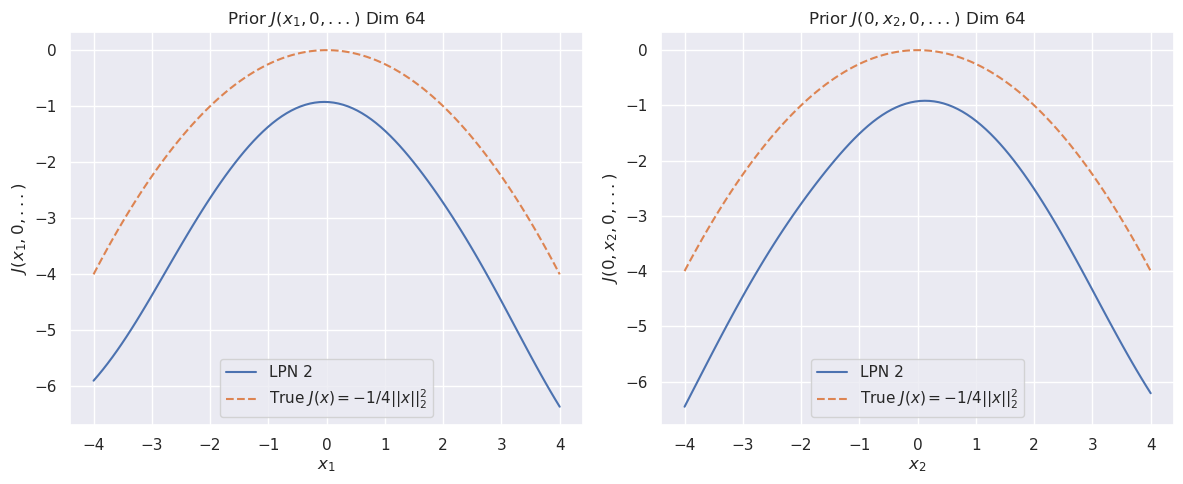

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)